## 문제출제 목적
- 내부요인(상품력, 시즌별 상품변화) + 외부요인(날씨,이슈,시청률) 을 통해 프로그램 매출 실적을 사전에 예측하고 대응

### 데이터 설명
- 판매가 0원(무형, 보험 상품)은 추정 제외
- 매주 토요일 18:00 ~ 18:20은 제외(이미 제외되어 있음)
- 편성시간은 10~60분 내외
- 편성표는 6:20~2:20(익일)으로 구성(심야시간대 제외)
- 취급액 = 판매단가 * 주문량

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import locale                                                           
import re
from tqdm import tqdm_notebook,tqdm,notebook
import matplotlib.pylab as plt
import json
import pickle
import torch
import warnings
warnings.filterwarnings("ignore") 
# import pickle5

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
locale.setlocale(locale.LC_ALL, 'ko_KR.UTF-8') 

'ko_KR.UTF-8'

## **데이터 load 및 간단한 처리**

In [2]:
file_root = '../2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)_update_200818/01_제공데이터/'
with open('../data/merged_data_concat.pickle', 'rb') as f:
    performance_data = pickle.load(f)
with open('../data/embed_mat2020-09-16.pickle', 'rb') as f:
    weight = pickle.load(f)
with open('../data/vocab.json', 'rb') as f:
    vocab = json.load(f)
rating_data = pd.read_excel(file_root+'2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx',header=1)

In [3]:
display(performance_data.head())

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,...,배당수익률(%),주가이익비율,주가자산비율,시가지수,고가지수,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원),뉴스시청률
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8


In [4]:
performance_data.columns

Index(['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액', '판매량',
       '요일', 'hour', 'minute', 'date', 'month', 'season', 'mean_rating',
       'holiday', 'holiday_yn', '기온', '누적강수량', '풍속', '습도', '현재지수', '대비',
       '등락률(%)', '배당수익률(%)', '주가이익비율', '주가자산비율', '시가지수', '고가지수', '저가지수',
       '거래량(천주)', '거래대금(백만원)', '상장시가총액(백만원)', '뉴스시청률'],
      dtype='object')

In [5]:
performance_data['방송일시'] = performance_data['방송일시'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

## **EDA**

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


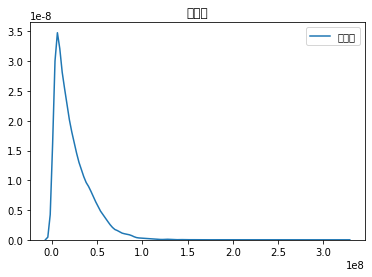

In [6]:
plt.title('취급액')
sns.kdeplot(performance_data[performance_data.취급액!=-1]['취급액'])
plt.show()

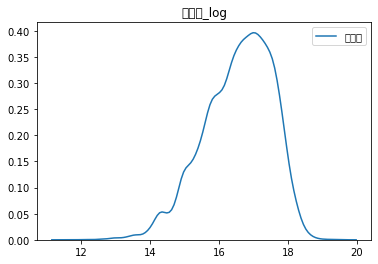

In [7]:
plt.title('취급액_log')
sns.kdeplot(performance_data[performance_data.취급액!=-1]['취급액'].map(lambda i: np.log(i) if i > 0 else 0))
plt.show()

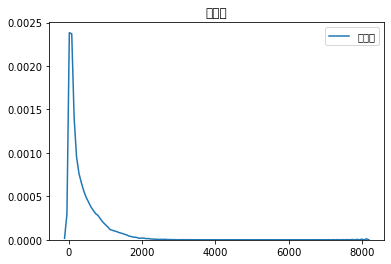

In [8]:
plt.title('판매량')
sns.kdeplot(performance_data[performance_data.취급액!=-1]['판매량'])
plt.show()

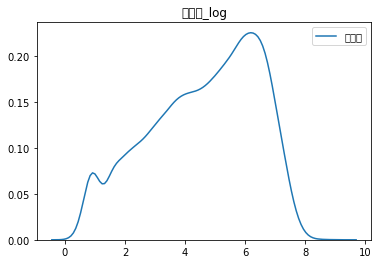

In [9]:
plt.title('판매량_log')
sns.kdeplot(performance_data[performance_data.취급액!=-1]['판매량'].map(lambda i: np.log(i) if i > 0 else 0))
plt.show()

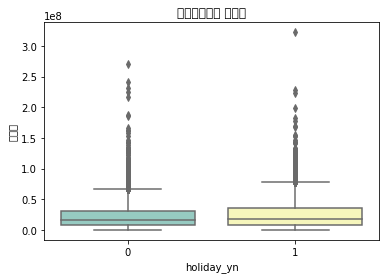

In [10]:
plt.title('공휴일여부별 취급액')
sns.boxplot(x = "holiday_yn", y = "취급액", data = performance_data[performance_data.취급액!=-1], palette = "Set3")
plt.xlabel('holiday_yn')
plt.ylabel('취급액')
plt.show()

-> 이걸로는 크게 차이가 없어보인다. 월별로 쪼개서 더 자세하게 봐야할듯

In [11]:
performance_data.상품군.unique()

array(['의류', '속옷', '주방', '농수축', '이미용', '가전', '생활용품', '건강기능', '잡화', '가구',
       '침구'], dtype=object)

In [12]:
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,...,배당수익률(%),주가이익비율,주가자산비율,시가지수,고가지수,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원),뉴스시청률
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,...,1.93,9.58,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8


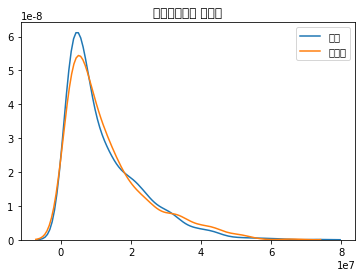

In [13]:
plt.title('공휴일여부별 취급액')
sns.kdeplot(performance_data[performance_data.취급액!=-1].query('(holiday_yn == 0) and (상품군 == "가구")')['취급액'], label = '평일')
sns.kdeplot(performance_data[performance_data.취급액!=-1].query('(holiday_yn == 1) and (상품군 == "가구")')['취급액'], label = '공휴일')
plt.show()

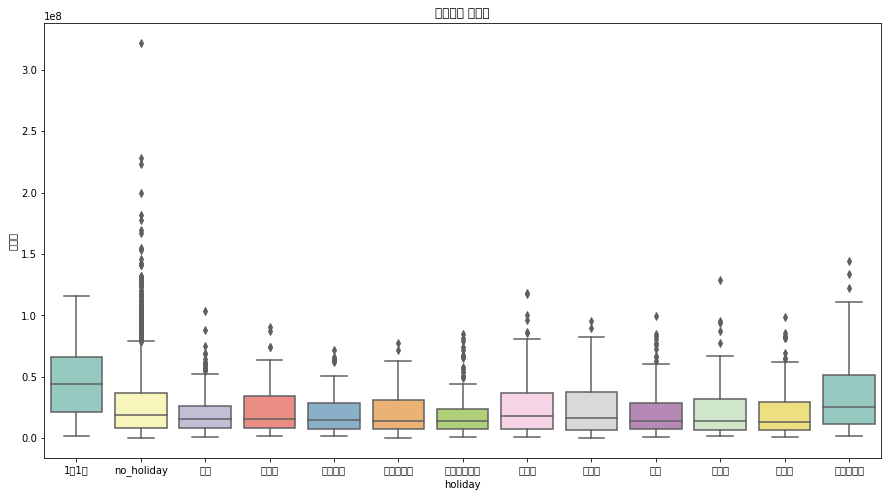

In [14]:
plt.figure(figsize=(15,8))
plt.title('공휴일별 취급액')
sns.boxplot(x = "holiday", y = "취급액", data = performance_data[performance_data.취급액!=-1][performance_data[performance_data.취급액!=-1].holiday_yn == 1], palette = "Set3")
plt.xlabel('holiday')
plt.ylabel('취급액')
plt.show()

-> 공휴일끼리 비교해봤을떄는 차이가 좀 있어보인다. 근데 의외로 설날과 추석이 저조함. 공휴일 전날들을 확인해 봐야할 듯.

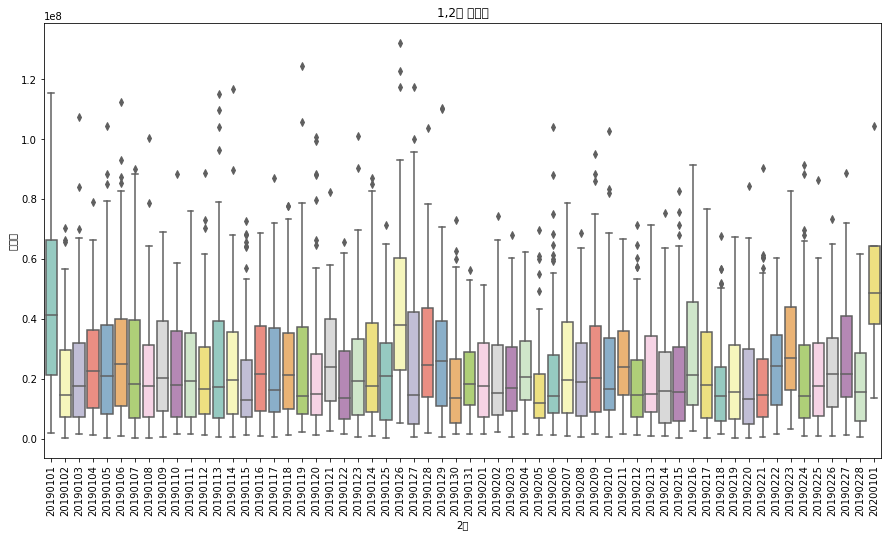

In [15]:
plt.figure(figsize=(15,8))
plt.title('1,2월 취급액')
sns.boxplot(x = "date", y = "취급액", data = performance_data[performance_data.취급액!=-1][performance_data[performance_data.취급액!=-1].month.isin([1,2])], palette = "Set3")
plt.xticks(rotation=90)
plt.xlabel('2월')
plt.ylabel('취급액')
plt.show()

-> 솔직히 잘 모르겠다. 상품군별로 따로 쪼개서 확인해봐야 할듯

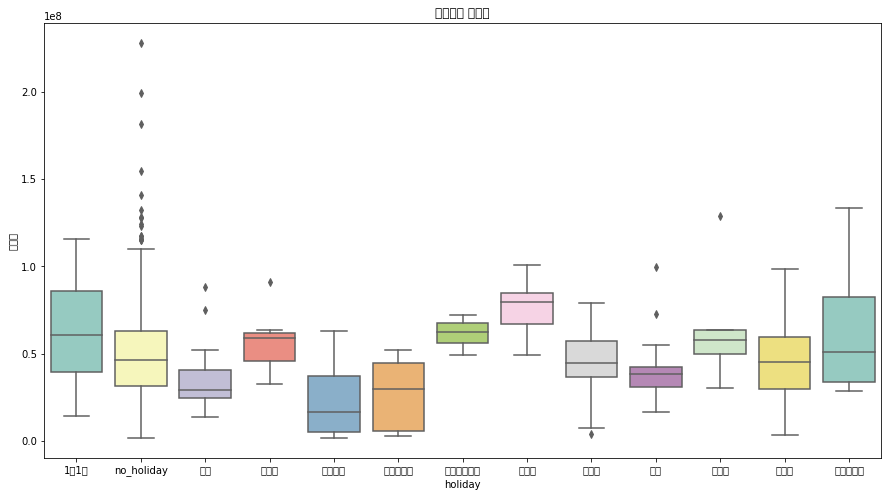

In [16]:
plt.figure(figsize=(15,8))
plt.title('공휴일별 취급액')
sns.boxplot(x = "holiday", y = "취급액", data = performance_data[performance_data.취급액!=-1][(performance_data[performance_data.취급액!=-1].holiday_yn == 1)
                                                                                        & (performance_data[performance_data.취급액!=-1].상품군 == '농수축')], palette = "Set3")
plt.xlabel('holiday')
plt.ylabel('취급액')
plt.show()

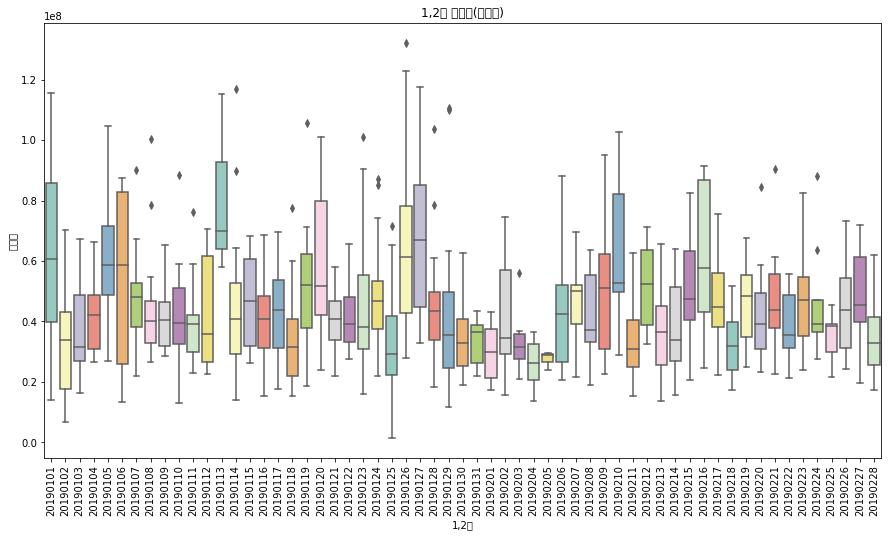

In [17]:
# 설날(2월 4~6일)
plt.figure(figsize=(15,8))
plt.title('1,2월 취급액(농수축)')
sns.boxplot(x = "date", y = "취급액", data = performance_data[performance_data.취급액!=-1][(performance_data[performance_data.취급액!=-1].month.isin([1,2])) 
                                                                                     & (performance_data[performance_data.취급액!=-1].상품군 == '농수축')], palette = "Set3")
plt.xticks(rotation=90)
plt.xlabel('1,2월')
plt.ylabel('취급액')
plt.show()

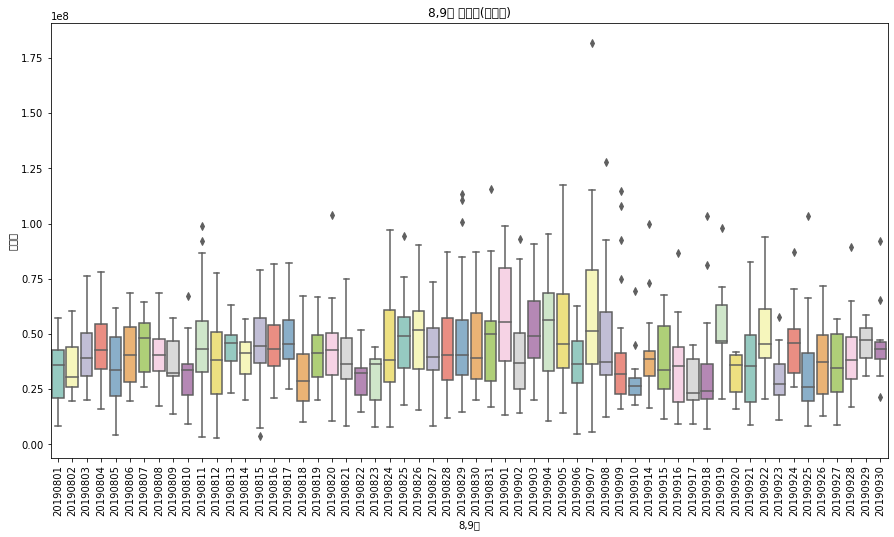

In [18]:
# 추석(9월 12~14일)
plt.figure(figsize=(15,8))
plt.title('8,9월 취급액(농수축)')
sns.boxplot(x = "date", y = "취급액", data = performance_data[performance_data.취급액!=-1][(performance_data[performance_data.취급액!=-1].month.isin([8,9]))
                                                                                     & (performance_data[performance_data.취급액!=-1].상품군 == '농수축')], palette = "Set3")
plt.xticks(rotation=90)
plt.xlabel('8,9월')
plt.ylabel('취급액')
plt.show()

In [19]:
# 요일별로 팔리는 상품의 취급액 합
d1 = performance_data[performance_data.취급액!=-1].groupby('요일')['취급액'].agg([('일별총취급액','sum')]).reset_index()
# 요일별로 어느 가격대의 제품이 팔리는지 파악
d2 = performance_data[performance_data.취급액!=-1].groupby('요일')['판매단가'].agg([('일별평균판매단가','mean')]).reset_index()
# 요일별로 어떤 상품군이 
d3 = pd.pivot_table(performance_data[performance_data.취급액!=-1], index='요일', columns='상품군', values='판매단가', 
                   aggfunc=np.size, fill_value=0).reset_index()
d4 = pd.pivot_table(performance_data[performance_data.취급액!=-1], index='hour', columns='상품군', values='판매단가', 
                   aggfunc=np.size, fill_value=0).reset_index()

In [20]:
count_sum = []
for i in d3.iloc[:,1:].iterrows():
    count_sum.append(sum(i[1]))
    
d3['합계'] = count_sum

for i in range(len(d3)):
    d3.iloc[i,1:-1] = d3.iloc[i,1:]/d3.합계[i]
d3

상품군,요일,가구,가전,건강기능,농수축,생활용품,속옷,의류,이미용,잡화,주방,침구,합계
0,금요일,0.070576,0.133468,0.028918,0.107786,0.091203,0.114459,0.099494,0.036198,0.119919,0.185844,0.012133,4945
1,목요일,0.061390,0.155349,0.033162,0.119424,0.087051,0.101066,0.104619,0.034149,0.107580,0.175484,0.020726,5066
2,수요일,0.071387,0.129741,0.024898,0.112429,0.075083,0.099981,0.106011,0.036180,0.093756,0.216495,0.034040,5141
3,월요일,0.076985,0.111267,0.018845,0.124098,0.085204,0.118685,0.115076,0.035886,0.098035,0.194266,0.021652,4988
4,일요일,0.061838,0.190715,0.013870,0.083992,0.073974,0.112310,0.156232,0.040262,0.078020,0.167983,0.020805,5191
5,토요일,0.049908,0.188129,0.013350,0.103307,0.067776,0.100021,0.166769,0.035531,0.130006,0.142124,0.003081,4869
6,화요일,0.063140,0.113535,0.022398,0.117783,0.067967,0.126665,0.109481,0.039776,0.105619,0.215679,0.017957,5179


#### **노출시간 탐색**

In [21]:
performance_data[performance_data.취급액!=-1]['노출(분)'].unique()

array([20.        , 30.        , 17.1       , 17.08333333, 27.08333333,
       16.1       , 16.08333333, 26.08333333, 16.33333333, 16.35      ,
       26.33333333, 16.05      , 26.03333333, 12.13333333, 16.01666667,
       16.03333333, 15.86666667, 16.51666667,  2.46666667, 16.2       ,
       15.85      , 15.36666667, 15.83333333, 16.16666667, 15.66666667,
       25.9       , 26.16666667, 25.21666667, 16.        , 14.66666667,
       24.66666667, 14.7       ,  2.81666667, 14.35      , 22.36666667,
       15.        , 25.        , 15.01666667, 15.03333333, 15.06666667,
       12.        , 10.        , 22.        , 13.        , 23.        ,
        3.        , 13.16666667, 12.66666667, 23.2       , 13.33333333,
       12.5       , 23.16666667,  3.16666667, 13.5       , 15.16666667,
       15.2       , 25.66666667, 14.83333333, 30.1       , 17.66666667,
        5.16666667,  8.85      , 15.5       , 15.08333333, 15.25      ,
       15.33333333,  5.33333333,  3.28333333, 20.06666667, 19.38

In [22]:
# 새벽1시 이후의 데이터는 제외하고 확인
except_lhour = performance_data[performance_data.취급액!=-1][performance_data[performance_data.취급액!=-1]['hour']!=1].reset_index(drop=True)
except_lhour['노출(분)'].unique()

array([20.        , 30.        , 12.13333333,  2.46666667, 25.21666667,
        2.81666667, 22.36666667, 10.        , 15.        , 30.1       ,
        8.85      ,  3.28333333, 20.06666667,  7.26666667, 18.25      ,
       15.01666667,  5.46666667, 11.33333333, 11.03333333, 12.9       ,
       29.98333333, 12.53333333,  9.7       , 40.        ,  3.45      ,
       10.96666667, 14.98333333, 18.01666667,  6.63333333])

In [23]:
except_lhour.iloc[9040:9050,:]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,...,배당수익률(%),주가이익비율,주가자산비율,시가지수,고가지수,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원),뉴스시청률
9040,2019-04-10 07:40:00,20.0,100335,201046,더블유베일 소프트 마카롱 니트 5종,의류,59000,22578000.0,382.677966,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9041,2019-04-10 08:00:00,20.0,100066,200156,무이자 아이넥스 프리미엄 올스텐 싱크선반,주방,94800,3005000.0,31.698312,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9042,2019-04-10 08:00:00,20.0,100066,200160,일시불 아이넥스 프리미엄 올스텐 싱크선반,주방,88800,4357000.0,49.065315,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9043,2019-04-10 08:20:00,20.0,100066,200156,무이자 아이넥스 프리미엄 올스텐 싱크선반,주방,94800,10177000.0,107.352321,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9044,2019-04-10 08:20:00,20.0,100066,200160,일시불 아이넥스 프리미엄 올스텐 싱크선반,주방,88800,16850000.0,189.752252,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9045,2019-04-10 08:40:00,20.0,100066,200156,무이자 아이넥스 프리미엄 올스텐 싱크선반,주방,94800,20605000.0,217.352321,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9046,2019-04-10 08:40:00,20.0,100066,200160,일시불 아이넥스 프리미엄 올스텐 싱크선반,주방,88800,29846000.0,336.103604,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9047,2019-04-10 09:00:00,20.0,100097,200269,일시불 올리고 가스와이드그릴 프리미엄형,주방,119000,8486000.0,71.310924,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9048,2019-04-10 09:00:00,20.0,100097,200265,무이자 올리고 가스와이드그릴레인지 프리미엄형,주방,129000,3916000.0,30.356589,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0
9049,2019-04-10 09:20:00,20.0,100097,200269,일시불 올리고 가스와이드그릴 프리미엄형,주방,119000,20831000.0,175.050420,수요일,...,1.75,10.53,0.96,2206.2,2225.02,2203.82,399695.0,5135094.0,1.473099e+09,12.0


**-> 노출시간이 18.016667분 같이 이상한 값인 경우 살펴보니 이전 방송시간부터 계속 판매하고 있었으며 해당 시간에 완판된 것으로 판단된다.**

**또한 거의 대부분의 상품이 1시간 단위로  배정이 되어있으며 일정 시간으로 쪼개져서 편성된다. 해당 상품의 시간이 소수점자리가 나오는 이상한 경우는 새벽 1시 이후의 데이터를 제외하고는 매진인 경우라고 생각할 수 있다.**

**-> 추후 테스트 데이터를 보았을 때 이런ㅁ식으로 매진을 판단하여 피쳐를 생성하는것은 어려울것으로 판단하여 넘어감.**

#### **시청률데이터 탐색**

In [24]:
rating_data = rating_data.iloc[:-1,:]

**-> 시청률데이터의 마지막행과 마지막열은 각 행, 열들의 평균으로 이루어짐.**

In [25]:
rating_data['hour'] = rating_data.시간대.apply(lambda x: x.split(':')[0])
rating_data['minute'] = rating_data.시간대.apply(lambda x: x.split(':')[1])
rating_data.hour = rating_data.hour.map(int)
rating_data.minute = rating_data.minute.map(int)

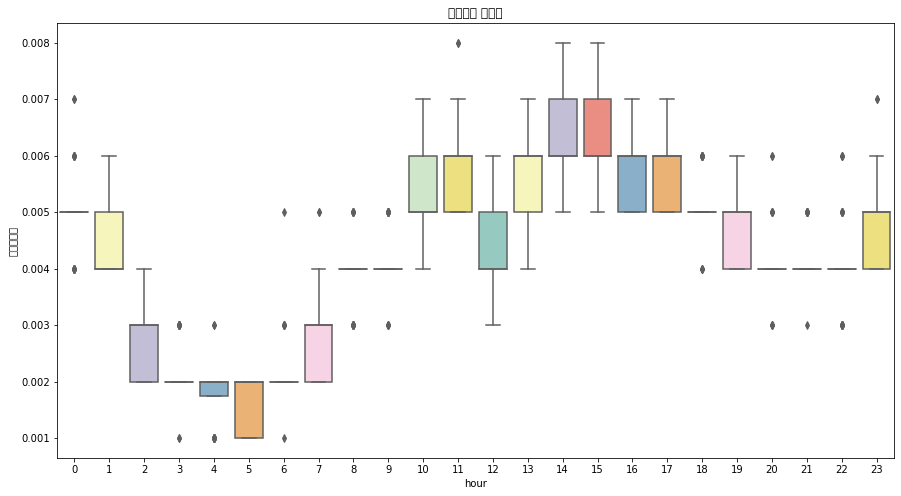

In [26]:
plt.figure(figsize=(15,8))
plt.title('시간대별 시청률')
sns.boxplot(x = "hour", y = "2019-01-01 to 2019-12-31", data = rating_data, palette = "Set3")
plt.xlabel('hour')
plt.ylabel('평균시청률')
plt.show()

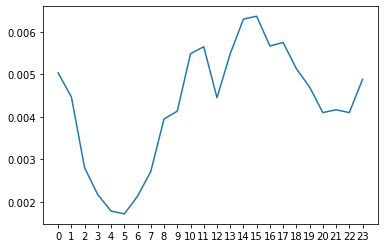

In [27]:
# 시간대별 평균 시청률
d = rating_data.groupby('hour')['2019-01-01 to 2019-12-31'].agg([('시간대별평균시청률', 'mean')]).reset_index()
plt.plot(d.hour,d.시간대별평균시청률)
plt.xticks(d.hour)
plt.show()

**-> 특정 시간대에 시청률이 높은것을 확인할 수 있다.**

## **변수 생성**

In [28]:
d4

상품군,hour,가구,가전,건강기능,농수축,생활용품,속옷,의류,이미용,잡화,주방,침구
0,0,92,75,21,6,194,287,345,63,247,69,8
1,1,14,12,37,84,185,385,283,135,257,36,70
2,2,2,0,5,4,15,10,9,10,8,3,4
3,6,26,0,104,20,208,197,358,88,114,196,18
4,7,13,22,192,18,156,197,376,79,229,178,0
5,8,10,12,55,5,185,203,364,73,365,321,6
6,9,0,46,43,13,128,144,381,87,374,337,0
7,10,15,168,22,182,80,131,284,38,405,541,9
8,11,0,74,22,253,81,174,215,24,408,476,96
9,12,9,94,31,144,111,91,161,100,229,635,141


**-> 상품군별로 주로 많이 판매하는 시간대가 정해져 있다.**

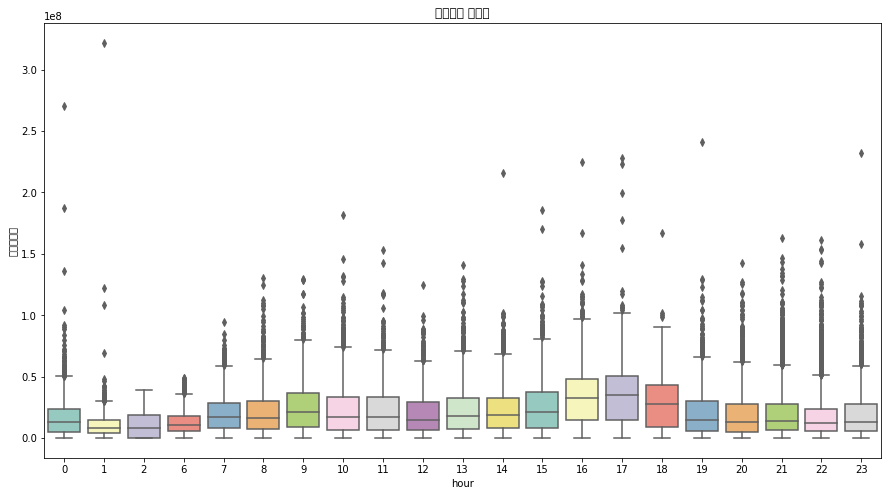

In [29]:
plt.figure(figsize=(15,8))
plt.title('시간대별 시청률')
sns.boxplot(x = "hour", y = "취급액", data = performance_data, palette = "Set3")
plt.xlabel('hour')
plt.ylabel('평균시청률')
plt.show()

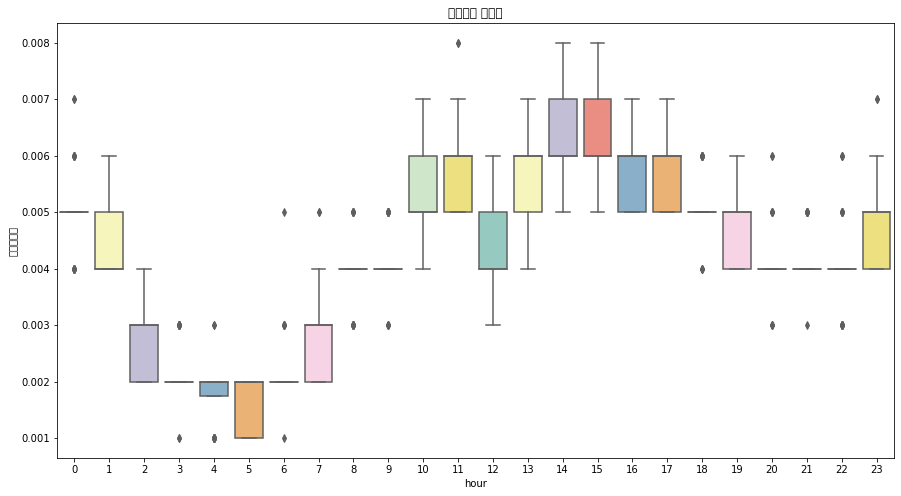

In [30]:
plt.figure(figsize=(15,8))
plt.title('시간대별 시청률')
sns.boxplot(x = "hour", y = "2019-01-01 to 2019-12-31", data = rating_data, palette = "Set3")
plt.xlabel('hour')
plt.ylabel('평균시청률')
plt.show()

In [31]:
# 시간대별 주요 판매시간을 엮어서 prime time 생성
def prime_t(x):
    if x in [10,11,12,13,14,15]:
        x = '점심'
    elif x in [16,17,18]:
        x = '오후'
    elif x in [21,22,23]:
        x = '저녁'
    elif x in [0,1]:
        x = '새벽'
    else:
        x = 'no_prime'
    return x
    
performance_data['prime_time'] = performance_data['hour'].apply(lambda x: prime_t(x))

### **소분류**

In [32]:
## 소분류 만들기
test = performance_data.loc[performance_data['상품군']=='주방']['상품명']
index = test.index
test = performance_data.loc[performance_data['상품군']=='주방']['상품명'].reset_index(drop=True)
list_kit =[]

for i in range(len(test)):
    if ( '냄비' in test[i]):
        list_kit.append('냄비')
    elif('밥솥' in test[i]):
        list_kit.append('밥솥')
    elif('가스레인지' in test[i]):
        list_kit.append('가스레인지')
    elif('에어프라이어' in test[i]):
        list_kit.append('에어프라이어')
    elif('믹서' in test[i]):
        list_kit.append('믹서')
    elif('커피머신' in test[i]):
        list_kit.append('커피머신')
    elif('오븐' in test[i]):
        list_kit.append('오븐')
    elif('레인지' in test[i]):
        list_kit.append('레인지')
    elif('글라스' in test[i]):
        list_kit.append('글라스')
    elif('도마' in test[i]):
        list_kit.append('도마')
    elif('행주' in test[i]):
        list_kit.append('행주')
    elif('싱크선반' in test[i]):
        list_kit.append('싱크선반')
    elif('후라이팬' in test[i]):
        list_kit.append('후라이팬')
    elif('건조기' in test[i]):
        list_kit.append('건조기')
    elif('싱크선반' in test[i]):
        list_kit.append('싱크선반')
    elif('프라이팬' in test[i]):
        list_kit.append('후라이팬')
    elif('착즙기' in test[i]):
        list_kit.append('착즙기')
    elif('맷돌' in test[i]):
        list_kit.append('맷돌')
    elif('건조대' in test[i]):
        list_kit.append('건조대')
    elif('용기' in test[i]):
        list_kit.append('용기')
    elif('진공포장기' in test[i]):
        list_kit.append('진공포장기')
    elif('가마솥' in test[i]):
        list_kit.append('가마솥')
    elif('티포트' in test[i]):
        list_kit.append('티포트')
    elif('그릴' in test[i]):
        list_kit.append('그릴')
    elif('멀티쿡' in test[i]):
        list_kit.append('멀티쿡')
    elif('블렌더' in test[i]):
        list_kit.append('블렌더')
    elif('다지기' in test[i]):
        list_kit.append('다지기')
        
    elif('전기렌인지' in test[i]):
        list_kit.append('레인지')
    elif('보온병' in test[i]):
        list_kit.append('텀블러')
    elif('지퍼백' in test[i]):
        list_kit.append('지퍼백')
    elif('수세미' in test[i]):
        list_kit.append('수세미')
    elif('텀블러' in test[i]):
        list_kit.append('텀블러')
    elif('참소쿠리' in test[i]):
        list_kit.append('참소쿠리')
        
    elif('티메이커' in test[i]):
        list_kit.append('티메이커')
    elif('식기세척기' in test[i]):
        list_kit.append('식기세척기')
    elif('퀵스퀴저' in test[i]):
        list_kit.append('퀵스퀴저')
    elif('중탕기' in test[i]):
        list_kit.append('중탕기')
    elif('키친툴' in test[i]):
        list_kit.append('멀티쿡')
    elif('팬' in test[i]):
        list_kit.append('후라이팬')
        
            
    elif('홈세트' in test[i]):
        list_kit.append('멀티쿡')
    elif('죽제조기' in test[i]):
        list_kit.append('죽제조기')
    elif('퀵스퀴저' in test[i]):
        list_kit.append('퀵스퀴저')
    elif('인덕션' in test[i]):
        list_kit.append('중탕기')
    elif('후레쉬' in test[i]):
        list_kit.append('멀티쿡')
    elif('디너세트' in test[i]):
        list_kit.append('멀티쿡')
    elif('칼' in test[i]):
        list_kit.append('도마')
    else:
        print(test[i])
        list_kit.append('기타_주방')

In [33]:
test = pd.DataFrame(test,columns=['상품명'])

In [34]:
test['index']=index
test['소분류'] = list_kit
#test.head()

In [35]:
test2 = performance_data.loc[performance_data['상품군']=='가전']['상품명']
index = test2.index
test2 = performance_data.loc[performance_data['상품군']=='가전']['상품명'].reset_index(drop=True)
list_ele = []

for i in range(len(test2)):
    if all(format in test2[i] for format in ['벽걸이','06']):
        list_ele.append('벽걸이_06')
    elif all(format in test2[i] for format in ['벽걸이','07']):
        list_ele.append('벽걸이_07')
    elif all(format in test2[i] for format in ['에어컨','07']):
        list_ele.append('벽걸이_07')
    elif all(format in test2[i] for format in ['벽걸이','09']):
        list_ele.append('벽걸이_07')
    elif all(format in test2[i] for format in ['벽걸이','10']):
        list_ele.append('벽걸이_10')
    elif all(format in test2[i] for format in ['벽걸이' ,'11']):
        list_ele.append('벽걸이_10')
    elif all(format in test2[i] for format in ['벽걸이' , '13']):
        list_ele.append('벽걸이_10')
        
    elif all(format in test2[i] for format in ['클래식' , '스탠드']):
        list_ele.append('에어컨_스탠드_클래식')    
    elif all(format in test2[i] for format in ['에어컨' , '스탠드']):
        list_ele.append('에어컨_스탠드')
    elif all(format in test2[i] for format in ['무풍', '스탠드']):
        list_ele.append('에어컨_스탠드')
    elif all(format in test2[i] for format in ['홈멀티' , '클래식']):
        list_ele.append('에어컨_홈멀티_클래식')
    elif all(format in test2[i] for format in ['에어컨' , '홈멀티']):
        list_ele.append('에어컨_홈멀티')
    elif all(format in test2[i] for format in ['무풍' , '홈멀티']):
        list_ele.append('에어컨_홈멀티')
    elif  all(format in test2[i] for format in ['에어컨' , '2IN1']):
        list_ele.append('에어컨_홈멀티')
    elif all(format in test2[i] for format in ['에어컨' , '2in1']):
        list_ele.append('에어컨_홈멀티')
    elif all(format in test2[i] for format in ['에어컨' , 'MC16VA2SAWGH']):
        list_ele.append('에어컨_홈멀티')
    elif all(format in test2[i] for format in ['에어컨' , 'MC16VA2SAW']):
        list_ele.append('에어컨_스탠드')    
        
        
    elif all(format in test2[i] for format in ['TV' , '55' , '삼성']):
        list_ele.append('TV_55')
    elif  all(format in test2[i] for format in ['TV' , '65' , '삼성']):
        list_ele.append('TV_65')
    elif all(format in test2[i] for format in ['TV' , '75' , '삼성']):
        list_ele.append('TV_75')
    elif  all(format in test2[i] for format in ['TV' , '55' , 'LG']):
        list_ele.append('TV_55')
    elif all(format in test2[i] for format in ['TV' , '70' , 'LG']):
        list_ele.append('TV_70')
    elif all(format in test2[i] for format in ['TV' , '65' , 'LG']):
        list_ele.append('TV_65')
    elif all(format in test2[i] for format in ['TV' , '75' , 'LG']):
        list_ele.append('TV_75')
        
    elif all(format in test2[i] for format in ['TV' , '55']):
        list_ele.append('TV_55')
    elif all(format in test2[i] for format in ['TV' , '70']):
        list_ele.append('TV_70')
    elif all(format in test2[i] for format in ['TV' , '65']):
        list_ele.append('TV_65')
    elif all(format in test2[i] for format in ['TV' , '75']):
        list_ele.append('TV_75')
        
    elif ('세탁기' in test2[i]):
        list_ele.append('세탁기')
    elif ('선풍기' in test2[i]):
        list_ele.append('선풍기')    
    
    elif all(format in test2[i] for format in ['냉장고' , '김치']):
        list_ele.append('김치냉장고')
    elif('냉장고' in test2[i]):
        list_ele.append('냉장고')  
        
        
    elif ('노트북' in test2[i]):
        list_ele.append('노트북')
    
    elif ('공기청정기' in test2[i]):
        list_ele.append('공기청정기')
        
    elif all(format in test2[i] for format in ['건조기' , '미니']):
        list_ele.append('미니건조기')
    
    elif ('건조기' in test2[i]):
        list_ele.append('건조기')
        
    elif ('청소기' in test2[i]):
        list_ele.append('청소기')
        
    elif ('스타일러' in test2[i]):
        list_ele.append('스타일러')
        
    
        
    elif('공청기' in test2[i]):
        list_ele.append('공기청정기')
        
    elif('로보킹' in test2[i]):
        list_ele.append('청소기')

    else:
        #print(test2[i])
        list_ele.append('기타_가전')

In [36]:
test2 = pd.DataFrame(test2,columns=['상품명'])

In [37]:
test2['index']=index
test2['소분류'] = list_ele
#test2.head()

In [38]:
test3 = performance_data.loc[performance_data['상품군']=='의류']['상품명']
index = test3.index
test3 = performance_data.loc[performance_data['상품군']=='의류']['상품명'].reset_index(drop=True)
list_clo = []

for i in range(len(test3)):
    if ( '코트' in test3[i]):
        list_clo.append('코트')
    elif ('티셔츠' in test3[i]):
        list_clo.append('티셔츠')
    elif ('셔츠' in test3[i]):
        list_clo.append('셔츠')
    elif ('무스탕' in test3[i]):
        list_clo.append('무스탕')
    elif('스웨터' in test3[i]):
        list_clo.append('스웨터')
    elif('팬츠' in test3[i]):
        list_clo.append('팬츠')
    elif('패딩' in test3[i]):
        list_clo.append('패딩')
    elif('터틀넥' in test3[i]):
        list_clo.append('터틀넥')
    elif('재킷' in test3[i]):
        list_clo.append('재킷')
    elif('트레이닝' in test3[i]):
        list_clo.append('트레이닝')
    elif('수트' in test3[i]):
        list_clo.append('수트')
    elif('데님' in test3[i]):
        list_clo.append('데님')
    elif('블라우스' in test3[i]):
        list_clo.append('블라우스')
    elif('원피스' in test3[i]):
        list_clo.append('원피스')
    elif('가디건' in test3[i]):
        list_clo.append('가디건')
    elif('맨투맨' in test3[i]):
        list_clo.append('맨투맨')
    elif('니트' in test3[i]):
        list_clo.append('니트')
    elif('자켓' in test3[i]):
        list_clo.append('재킷')
    elif('베스트' in test3[i]):
        list_clo.append('베스트')
    elif('구스다운' in test3[i]):
        list_clo.append('구스다운')
    elif('덕다운' in test3[i]):
        list_clo.append('덕다운')
    elif('썸머' in test3[i]):
        list_clo.append('썸머')
    elif('윈터' in test3[i]):
        list_clo.append('윈터')
    elif('기모' in test3[i]):
        list_clo.append('기모')
    elif('윈드' in test3[i]):
        list_clo.append('윈드')
    elif('점퍼' in test3[i]):
        list_clo.append('점퍼')
    elif('워터' in test3[i]):
        list_clo.append('워터')
    elif('아이스' in test3[i]):
        list_clo.append('아이스')
    elif('앙상블' in test3[i]):
        list_clo.append('앙상블')
    elif('이지웨어세트' in test3[i]):
        list_clo.append('이지웨어세트')
    elif('패키지' in test3[i]):
        list_clo.append('패키지')
    elif('세트' in test3[i]):
        list_clo.append('세트')
    elif('라인핏' in test3[i]):
        list_clo.append('팬츠')
    else:
        print(test3[i])
        list_clo.append('기타_의류')

In [39]:
test3 = pd.DataFrame(test3,columns=['상품명'])

In [40]:
test3['index']=index
test3['소분류'] = list_clo
#test3.head()

In [41]:
test4 = performance_data.loc[performance_data['상품군']=='속옷']['상품명']
index = test4.index
test4 = performance_data.loc[performance_data['상품군']=='속옷']['상품명'].reset_index(drop=True)
list_clo2 = []

for i in range(len(test4)):
    if ( '브라' in test4[i]):
        list_clo2.append('브라')    
    elif ('팬티' in test4[i]):
        list_clo2.append('팬티')
    elif ('드로즈' in test4[i]):
        list_clo2.append('드로즈')
    elif('런닝' in test4[i]):
        list_clo2.append('런닝')
    elif('트렁크' in test4[i]):
        list_clo2.append('트렁크')
    elif('레깅스' in test4[i]):
        list_clo2.append('레깅스')
    elif('언더셔츠' in test4[i]):
        list_clo2.append('언더셔츠')
    elif('베이스레이어' in test4[i]):
        list_clo2.append('베이스레이어')
    elif('주니어' in test4[i]):
        list_clo2.append('주니어')
    elif('기모' in test4[i]):
        list_clo2.append('기모')
    elif('극세사' in test4[i]):
        list_clo2.append('극세사')
    elif('레이스' in test4[i]):
        list_clo2.append('레이스')
    elif('쿨' in test4[i]):
        list_clo2.append('쿨')
    elif('언더탑' in test4[i]):
        list_clo2.append('언더탑')
    elif('지퍼' in test4[i]):
        list_clo2.append('지퍼')
    elif('쉐이퍼' in test4[i]):
        list_clo2.append('쉐이퍼')
    elif('패키지' in test4[i]):
        list_clo2.append('패키지')

    elif('원피스' in test4[i]):
        list_clo2.append('원피스')
    elif('썸머' in test4[i]):
        list_clo2.append('썸머')
    elif('이너웨어' in test4[i]):
        list_clo2.append('이너웨어')
    elif('란쥬' in test4[i]):
        list_clo2.append('란쥬')
    elif('에어로웜' in test4[i]):
        list_clo2.append('에어로웜')
    elif('홈웨어' in test4[i]):
        list_clo2.append('홈웨어')
    else:
        print(test4[i])
        list_clo2.append('기타_속옷')

In [42]:
test4 = pd.DataFrame(test4,columns=['상품명'])

In [43]:
test4['index']=index
test4['소분류'] = list_clo2

In [44]:
test5 = performance_data.loc[performance_data['상품군']=='잡화']['상품명']
index = test5.index
test5 = performance_data.loc[performance_data['상품군']=='잡화']['상품명'].reset_index(drop=True)
etc = []

for i in range(len(test5)):
    if ( '부츠' in test5[i]):
        etc.append('부츠')    
        
#     elif all(format in test5[i] for format in ['백','구찌']):
#         etc.append('명품백')
#     elif all(format in test5[i] for format in ['백' , '프라다']):
#         etc.append('명품백')
#     elif all(format in test5[i] for format in ['백' , '버버리']):
#         etc.append('명품백')
#     elif all(format in test5[i] for format in ['백' , '생로랑']):
#         etc.append('명품백')
    
#     elif all(format in test5[i] for format in ['지갑' , '구찌']):
#         etc.append('명품지갑')
#     elif all(format in test5[i] for format in ['지갑' , '프라다']):
#         etc.append('명품지갑')
#     elif all(format in test5[i] for format in ['지갑' , '버버리']):
#         etc.append('명품지갑')
#     elif all(format in test5[i] for format in ['지갑' , '생로랑']):
#         etc.append('명품지갑')
        
#     elif all(format in test5[i] for format in ['순금' , '11' , 'g']):
#         etc.append('순금_11g') 
#     elif all(format in test5[i] for format in ['순금' , '13' , 'g']):
#         etc.append('순금_13g')
#     elif all(format in test5[i] for format in ['순금' , '18', 'g']):
#         etc.append('순금_18g')
#     elif all(format in test5[i] for format in ['순금' , '35' , 'g']):
#         etc.append('순금_35g')
#     elif all(format in test5[i] for format in ['순금' , '37' , 'g']):
#         etc.append('순금_37g')
        
    elif ('시계' in test5[i]):
        etc.append('시계')
    elif ('핸드백' in test5[i]):
        etc.append('핸드백')
    elif('워킹화' in test5[i]):
        etc.append('워킹화')
    elif('트레킹화' in test5[i]):
        etc.append('트레킹화')
    elif('다이아몬드' in test5[i]):
        etc.append('다이아몬드')
    elif('악어' in test5[i]):
        etc.append('악어')
    elif('백팩' in test5[i]):
        etc.append('백팩')
    elif('소가죽' in test5[i]):
        etc.append('소가죽')
    elif('기모' in test5[i]):
        etc.append('기모')
    elif('스니커즈' in test5[i]):
        etc.append('스니커즈')
    elif('선글라스' in test5[i]):
        etc.append('선글라스')
    elif('버킷백' in test5[i]):
        etc.append('버킷백')
    elif('토트백' in test5[i]):
        etc.append('토트백')
    elif('크로스' in test5[i]):
        etc.append('크로스')
    elif('여행가방' in test5[i]):
        etc.append('여행가방')
    elif('샌들' in test5[i]):
        etc.append('샌들')
    elif('러닝화' in test5[i]):
        etc.append('러닝화')
    elif('슬립온' in test5[i]):
        etc.append('슬립온')
    elif('목걸이' in test5[i]):
        etc.append('목걸이')
    elif('팔찌' in test5[i]):
        etc.append('팔찌')
    elif('귀걸이' in test5[i]):
        etc.append('귀걸이')
    elif('반지' in test5[i]):
        etc.append('반지')
    elif('사첼' in test5[i]):
        etc.append('사첼')
    elif('모자' in test5[i]):
        etc.append('모자')
    elif('방한화' in test5[i]):
        etc.append('방한화')
    elif('백' in test5[i]):
        etc.append('백')
    elif('쥬얼리' in test5[i]):
        etc.append('쥬얼리')
    elif('슈즈' in test5[i]):
        etc.append('슈즈')
    elif('주얼리' in test5[i]):
        etc.append('쥬얼리')
    elif('지갑' in test5[i]):
        etc.append('지갑')
    elif('펌프스' in test5[i]):
        etc.append('펌프스')
    elif('밍크' in test5[i]):
        etc.append('밍크')
    elif('스카프' in test5[i]):
        etc.append('스카프')
    elif('탑핸들' in test5[i]):
        etc.append('탑핸들')
    elif('머플러' in test5[i]):
        etc.append('머플러') 

        
    elif('리스틀릿' in test5[i]):
        etc.append('리스틀릿')
    elif('장갑' in test5[i]):
        etc.append('장갑')
    elif('숄더' in test5[i]):
        etc.append('숄더')
    elif('양산' in test5[i]):
        etc.append('양산')
    elif('링' in test5[i]):
        etc.append('반지')
    elif('골드바' in test5[i]):
        etc.append('골드바')
    elif('캐리올' in test5[i]):
        etc.append('캐리올')
    
    elif('남성화' in test5[i]):
        etc.append('운동화') 
        

    else:
        print(test5[i])
        etc.append('기타_잡화')

프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
알비에로 마르티니 1A클라쎄 지오 울버튼 케이프
알비에로 마르티니 1A클라쎄 지오 울버튼 케이프
프라다 비텔로 피닉스 보스턴
프라다 비텔로 피닉스 보스턴
[루이띠에] 순금 41.25g 헤라 컬렉션
[루이띠에] 순금 41.25g 헤라 컬렉션
[루이띠에] 순금 41.25g 헤라 컬렉션
[루이띠에] 순금 41.25g 헤라 컬렉션
프라다 비텔로 피닉스 보스턴


In [45]:
test5 = pd.DataFrame(test5,columns=['상품명'])

In [46]:
test5['index']=index
test5['소분류'] = etc

In [47]:
test6 = performance_data.loc[performance_data['상품군']=='농수축']['상품명']
index = test6.index
test6 = performance_data.loc[performance_data['상품군']=='농수축']['상품명'].reset_index(drop=True)
list_agr  = []

for i in range(len(test6)):
    if ( '꼬막' in test6[i]):
        list_agr.append('꼬막')    
    elif ('황태' in test6[i]):
        list_agr.append('황태')
    elif ('전복' in test6[i]):
        list_agr.append('전복')
    elif('메주' in test6[i]):
        list_agr.append('메주')
    elif('갈비' in test6[i]):
        list_agr.append('고기')
    elif('매생이' in test6[i]):
        list_agr.append('매생이') 
    elif('문어' in test6[i]):
        list_agr.append('문어')
    elif('꽃게' in test6[i]):
        list_agr.append('꽃게')
    elif('동태포' in test6[i]):
        list_agr.append('동태포')
    elif('오징어' in test6[i]):
        list_agr.append('오징어')
    elif('김치' in test6[i]):
        list_agr.append('김치')
    elif('고등어' in test6[i]):
        list_agr.append('고등어')
    elif('가자미' in test6[i]):
        list_agr.append('가자미')
    elif('다시팩' in test6[i]):
        list_agr.append('다시팩')
    elif('쌀' in test6[i]):
        list_agr.append('쌀')
    elif('장어' in test6[i]):
        list_agr.append('장어')
    elif('쥐포' in test6[i]):
        list_agr.append('쥐포')
        
    elif('홍어' in test6[i]):
        list_agr.append('홍어')
    elif('오렌지' in test6[i]):
        list_agr.append('오렌지')
    elif('모시떡' in test6[i]):
        list_agr.append('모시떡')
    elif('곱창' in test6[i]):
        list_agr.append('곱창')
    elif('대구' in test6[i]):
        list_agr.append('대구')
    elif('도가니탕' in test6[i]):
        list_agr.append('도가니탕')
    elif('삼계탕' in test6[i]):
        list_agr.append('삼계탕')
    elif('치마살' in test6[i]):
        list_agr.append('치마살')
    elif('갈치' in test6[i]):
        list_agr.append('갈치')
        
    elif('굴비' in test6[i]):
        list_agr.append('굴비')
    elif('두유' in test6[i]):
        list_agr.append('두유')
    elif('곰탕' in test6[i]):
        list_agr.append('국')
    elif('한우' in test6[i]):
        list_agr.append('고기')
        
    elif('장조림' in test6[i]):
        list_agr.append('장조림')
    elif('꿀' in test6[i]):
        list_agr.append('꿀')
    elif('재첩국' in test6[i]):
        list_agr.append('국')
    elif('병어' in test6[i]):
        list_agr.append('병어')
    elif('선식' in test6[i]):
        list_agr.append('선식')
    elif('매실' in test6[i]):
        list_agr.append('매실')
    elif('감말랭이' in test6[i]):
        list_agr.append('감말랭이')
    elif('낙지' in test6[i]):
        list_agr.append('낙지')
        
    elif('호빵' in test6[i]):
        list_agr.append('간식')
    elif('시래기' in test6[i]):
        list_agr.append('시래기')
    elif('고춧가루' in test6[i]):
        list_agr.append('고춧가루')
    elif('강정바' in test6[i]):
        list_agr.append('강정바')
    elif('구이' in test6[i]):
        list_agr.append('고기')
    elif('돼지' in test6[i]):
        list_agr.append('고기')
    elif('오리' in test6[i]):
        list_agr.append('고기')
    elif('낙지' in test6[i]):
        list_agr.append('낙지')  
    elif('과메기' in test6[i]):
        list_agr.append('과메기')
    elif('젓갈' in test6[i]):
        list_agr.append('젓갈')
    elif('새우' in test6[i]):
        list_agr.append('새우')
    elif('굴' in test6[i]):
        list_agr.append('굴')
    elif('랍스터' in test6[i]):
        list_agr.append('랍스터')  
    elif('닭발' in test6[i]):
        list_agr.append('닭발')
    elif('사과' in test6[i]):
        list_agr.append('과일')
    elif('샤인머스켓' in test6[i]):
        list_agr.append('과일')
    elif('한라봉' in test6[i]):
        list_agr.append('과일')
    elif('옥수수' in test6[i]):
        list_agr.append('옥수수')
    elif('감자탕' in test6[i]):
        list_agr.append('국')

        
    elif('조기' in test6[i]):
        list_agr.append('조기')
    elif('우삽겹' in test6[i]):
        list_agr.append('고기')
    elif('배즙' in test6[i]):
        list_agr.append('배즙')
    elif('수산물' in test6[i]):
        list_agr.append('수산물')
        
    elif('곡물' in test6[i]):
        list_agr.append('선식')
    elif('국밥' in test6[i]):
        list_agr.append('국')
    elif('만두' in test6[i]):
        list_agr.append('간식')
    elif('귤' in test6[i]):
        list_agr.append('과일')
    elif('육포' in test6[i]):
        list_agr.append('쥐포')
    elif('쥐치포' in test6[i]):
        list_agr.append('쥐포')
    elif('해장국' in test6[i]):
        list_agr.append('국')
    elif('냉면' in test6[i]):
        list_agr.append('국')
    elif('해물' in test6[i]):
        list_agr.append('수산물')
    elif('치킨' in test6[i]):
        list_agr.append('치킨')
    elif('키위' in test6[i]):
        list_agr.append('과일')
    elif('돈' in test6[i]):
        list_agr.append('고기')
    
    elif('우럭' in test6[i]):
        list_agr.append('병어')
    elif('마시는한끼' in test6[i]):
        list_agr.append('선식')
    else:
        #print(test6[i])
        list_agr.append('기타_농수축')

In [48]:
test6 = pd.DataFrame(test6,columns=['상품명'])

In [49]:
test6['index']=index
test6['소분류'] =list_agr

In [50]:
test7 = performance_data.loc[performance_data['상품군']=='생활용품']['상품명']
index = test7.index
test7 = performance_data.loc[performance_data['상품군']=='생활용품']['상품명'].reset_index(drop=True)
list_lif  = []

for i in range(len(test7)):
    if ( '비데' in test7[i]):
        list_lif.append('비데')  
    elif('베개' in test7[i]):
        list_lif.append('베개')    
    elif all(format in test7[i] for format in ['타퍼' , '슈퍼싱글']):
        list_lif.append('토퍼_슈퍼싱글')
    elif all(format in test7[i] for format in ['타퍼' , '퀸']):
        list_lif.append('토퍼_퀸')
    elif all(format in test7[i] for format in ['타퍼' , '킹']):
        list_lif.append('토퍼_킹')
    elif('패치' in test7[i]):
        list_lif.append('패치')    
    elif ('마스크' in test7[i]):
        list_lif.append('마스크')
    elif ('청소기' in test7[i]):
        list_lif.append('청소기')
    elif('이볼브' in test7[i]):
        list_lif.append('이볼브')
    elif('선글라스' in test7[i]):
        list_lif.append('선글라스')
    elif('예초기' in test7[i]):
        list_lif.append('예초기') 
    elif('면도기' in test7[i]):
        list_lif.append('면도기')
    elif('안마' in test7[i]):
        list_lif.append('안마')
    elif('마사지기' in test7[i]):
        list_lif.append('마사지기')
    elif('블랙박스' in test7[i]):
        list_lif.append('블랙박스')
    elif('옷걸이' in test7[i]):
        list_lif.append('옷걸이')
    elif('스쿼트머신' in test7[i]):
        list_lif.append('스쿼트머신')
    elif('낚시' in test7[i]):
        list_lif.append('낚시')
    elif('건조기' in test7[i]):
        list_lif.append('섬유유연제')
    elif('매트릭스' in test7[i]):
        list_lif.append('매트릭스')
    elif('코일카매트' in test7[i]):
        list_lif.append('코일카매트')
    elif('온수매트' in test7[i]):
        list_lif.append('온수매트')
        
    elif('샤워기' in test7[i]):
        list_lif.append('샤워기')
    elif('단열벽지' in test7[i]):
        list_lif.append('단열벽지')
    elif('서큘레이터' in test7[i]):
        list_lif.append('서큘레이터')
    elif('배관청소' in test7[i]):
        list_lif.append('배관청소')
    elif('상' in test7[i]):
        list_lif.append('상')
        
    elif('행거' in test7[i]):
        list_lif.append('행거')
    elif('리빙박스' in test7[i]):
        list_lif.append('리빙박스')
    elif('한장빨래' in test7[i]):
        list_lif.append('섬유유연제')
    elif('빨래' in test7[i]):
        list_lif.append('빨래')
    elif('매트' in test7[i]):
        list_lif.append('매트')
    elif('면도날' in test7[i]):
        list_lif.append('면도날')
    
    elif('통증패치' in test7[i]):
        list_lif.append('패치')
    elif('도어락' in test7[i]):
        list_lif.append('도어락')
    elif('벽지' in test7[i]):
        list_lif.append('벽지')
    elif('다리미' in test7[i]):
        list_lif.append('다리미')
    elif('히터' in test7[i]):
        list_lif.append('히터')
        
    elif('선풍기' in test7[i]):
        list_lif.append('선풍기')
    elif('반신욕' in test7[i]):
        list_lif.append('반신욕')
    elif('바리캉' in test7[i]):
        list_lif.append('바리캉')
    elif('LED' in test7[i]):
        list_lif.append('LED')
    elif('안전스틱' in test7[i]):
        list_lif.append('안전스틱')
        
    elif('공기청정기' in test7[i]):
        list_lif.append('공기청정기')
    elif('블루투스' in test7[i]):
        list_lif.append('블루투스')
    elif('메모리폼' in test7[i]):
        list_lif.append('메모리폼')
    elif('플래티늄' in test7[i]):
        list_lif.append('플래티늄')
    elif('스피드랙' in test7[i]):
        list_lif.append('선반')
        
    elif('견인기기' in test7[i]):
        list_lif.append('견인기기')
    elif('자세밴드' in test7[i]):
        list_lif.append('자세밴드')
    elif('공구' in test7[i]):
        list_lif.append('공구')
    elif('오디오' in test7[i]):
        list_lif.append('오디오')
    elif('수액패치' in test7[i]):
        list_lif.append('수액패치')
        
    elif('거름통' in test7[i]):
        list_lif.append('거름통')
    elif('디퓨저' in test7[i]):
        list_lif.append('디퓨저')
    elif('의자' in test7[i]):
        list_lif.append('의자')
    elif('테이블' in test7[i]):
        list_lif.append('테이블')
    elif('체어' in test7[i]):
        list_lif.append('의자')      

    elif('세제' in test7[i]):
        list_lif.append('섬유유연제')    
    elif('섬유유연제' in test7[i]):
        list_lif.append('섬유유연제')
    elif('동전패치' in test7[i]):
        list_lif.append('패치')
    elif('클리너' in test7[i]):
        list_lif.append('클리너')  
    elif('치약' in test7[i]):
        list_lif.append('치약')
    elif('워킹머신' in test7[i]):
        list_lif.append('워킹머신')
    elif('혈압계' in test7[i]):
        list_lif.append('혈압계') 
    elif('테라피' in test7[i]):
        list_lif.append('테라피') 
    
    elif('윈큘레이터' in test7[i]):
        list_lif.append('선풍기')  
    elif('선반' in test7[i]):
        list_lif.append('선반')
    elif('써큘레이터' in test7[i]):
        list_lif.append('선풍기')
    elif all(format in test7[i] for format in ['무빙' , '에어컨']):
        list_lif.append('벽걸이_06') 
    elif all(format in test7[i] for format in ['이동식' , '에어컨']):
        list_lif.append('벽걸이_06') 
    elif all(format in test7[i] for format in ['창문형' , '에어컨']):
        list_lif.append('벽걸이_07') 
     
    elif('에어쿨러' in test7[i]):
        list_lif.append('선풍기')  
    elif('건조대' in test7[i]):
        list_lif.append('건조대')
    elif('써큘레이터' in test7[i]):
        list_lif.append('선풍기')
    elif('패드' in test7[i]):
        list_lif.append('매트') 
    elif('퀸사이즈' in test7[i]):
        list_lif.append('매트') 
    elif('배개' in test7[i]):
        list_lif.append('베개') 

    else:
        #print(test7[i])
        list_lif.append('기타_생활용품')

In [51]:
test7 = pd.DataFrame(test7,columns=['상품명'])

In [52]:
test7['index']=index
test7['소분류'] =list_lif

In [53]:
test8 = performance_data.loc[performance_data['상품군']=='가구']['상품명']
index = test8.index
test8 = performance_data.loc[performance_data['상품군']=='가구']['상품명'].reset_index(drop=True)
list_fur = []

for i in range(len(test8)):
    if  all(format in test8[i] for format in ['흙침대' , 'SS']):
        list_fur.append('흙침대_슈퍼싱글')    
    elif all(format in test8[i] for format in ['침대' , 'SS']):
        list_fur.append('침대_싱글')
    elif  all(format in test8[i] for format in ['흙침대' , '슈퍼싱글']):
        list_fur.append('흙침대_슈퍼싱글')
    elif all(format in test8[i] for format in ['침대' , '슈퍼싱글']):
        list_fur.append('침대_싱글')
    elif ('슈퍼킹' in test8[i]):
        list_fur.append('슈퍼킹')
    elif ('SK' in test8[i]):
        list_fur.append('슈퍼킹')
    
    elif all(format in test8[i] for format in ['흙침대' , 'K']):
        list_fur.append('흙침대_킹')    
    elif all(format in test8[i] for format in ['침대' , 'K']):
        list_fur.append('침대_킹')
    elif all(format in test8[i] for format in ['흙침대' , '킹']):
        list_fur.append('흙침대_킹')
    elif all(format in test8[i] for format in ['침대' , '킹']):
        list_fur.append('침대_킹')    
    elif all(format in test8[i] for format in ['흙침대' , 'Q']):
        list_fur.append('흙침대_퀸')    
    elif all(format in test8[i] for format in ['침대' , 'Q']):
        list_fur.append('침대_퀸')
    elif all(format in test8[i] for format in ['흙침대' , '퀸']):
        list_fur.append('흙침대_퀸')
    elif all(format in test8[i] for format in ['침대' , '퀸']):
        list_fur.append('침대_퀸')   
    elif all(format in test8[i] for format in ['흙침대' , 'S']):
        list_fur.append('흙침대_싱글')    
    elif all(format in test8[i] for format in ['침대' , 'S']):
        list_fur.append('침대_싱글')
    elif all(format in test8[i] for format in ['흙침대' , '싱글']):
        list_fur.append('흙침대_싱글')
    elif all(format in test8[i] for format in ['침대' , '싱글']):
        list_fur.append('침대_싱글')     

        
    elif all(format in test8[i] for format in ['소파' , '3인용']):
        list_fur.append('소파_3인용')
    elif all(format in test8[i] for format in ['소파' , '4인용']):
        list_fur.append('소파_4인용')    
    elif all(format in test8[i] for format in ['소파' , '6인용']):
        list_fur.append('소파_6인용')    
    elif all(format in test8[i] for format in ['카우치' , '소파']):
        list_fur.append('카우치소파')
    elif (('카우치') in test8[i]):
        list_fur.append('카우치침대')
        
    elif('붙박이장' in test8[i]):
        list_fur.append('붙박이장')
    elif('서랍장' in test8[i]):
        list_fur.append('서랍장')
    elif('시공패키지' in test8[i]):
        list_fur.append('시공패키지')
        
    elif ('리클라이닝' in test8[i]):
        list_fur.append('리클라이너')
    elif ('리클라이너' in test8[i]):
        list_fur.append('리클라이너')
    elif ('협탁' in test8[i]):
        list_fur.append('협탁')
        
    elif all(format in test8[i] for format in ['침실' , '세트']):
        list_fur.append('세트')  
    elif all(format in test8[i] for format in ['베드룸' , '세트']):
        list_fur.append('세트')  
    elif('매트리스' in test8[i]):
        list_fur.append('매트리스')  
    elif('하이바스' in test8[i]):
        list_fur.append('하이바스')  
    elif('거실장' in test8[i]):
        list_fur.append('거실장')  
    elif('화장대' in test8[i]):
        list_fur.append('화장대')  
    elif('테이블' in test8[i]):
        list_fur.append('테이블')
    elif('스툴' in test8[i]):
        list_fur.append('의자')
    else:
        print(test8[i])
        list_fur.append('기타_침구')

In [54]:
test8 = pd.DataFrame(test8,columns=['상품명'])

In [55]:
test8['index']=index
test8['소분류'] =list_fur

In [56]:
test9 = performance_data.loc[performance_data['상품군']=='이미용']['상품명']
index = test9.index
test9 = performance_data.loc[performance_data['상품군']=='이미용']['상품명'].reset_index(drop=True)
list_bea = []

for i in range(len(test9)):
    if ( '달팽이크림' in test9[i]):
        list_bea.append('크림')    
    elif ('기초' in test9[i]):
        list_bea.append('피부세트')
    elif('속눈썹' in test9[i]):
        list_bea.append('속눈썹')
    elif ('트리트먼트' in test9[i]):
        list_bea.append('트리트먼트')
    elif('코코넛크림' in test9[i]):
        list_bea.append('크림')
    elif('세럼' in test9[i]):
        list_bea.append('세럼')
    elif('고데기' in test9[i]):
        list_bea.append('고데기')
        
    elif ('샴푸' in test9[i]):
        list_bea.append('세안')
    elif ('세트' in test9[i]):
        list_bea.append('피부세트')
    elif ('썬스틱' in test9[i]):
        list_bea.append('썬스틱')    
    elif('에센스' in test9[i]):
        list_bea.append('에센스')  
        
    elif ('파운데이션' in test9[i]):
        list_bea.append('파운데이션')
    elif ('리프트' in test9[i]):
        list_bea.append('리프트')    
    elif('립스틱' in test9[i]):
        list_bea.append('립스틱')  
    elif ('클렌져' in test9[i]):
        list_bea.append('세안')
    elif ('샤워' in test9[i]):
        list_bea.append('세안')
    elif ('마스크팩' in test9[i]):
        list_bea.append('마스크팩')    
    elif('선스틱' in test9[i]):
        list_bea.append('썬스틱')  
        
    elif('쿠션' in test9[i]):
        list_bea.append('쿠션')  
    elif ('브로우' in test9[i]):
        list_bea.append('브로우')
    elif ('클렌징' in test9[i]):
        list_bea.append('세안')    
    elif('오일' in test9[i]):
        list_bea.append('오일')
        
    elif('마스크' in test9[i]):
        list_bea.append('마스크')  
    elif ('젤네일' in test9[i]):
        list_bea.append('젤네일')
    elif ('아이라이너' in test9[i]):
        list_bea.append('아이라이너')    
       
    elif('크림' in test9[i]):
        list_bea.append('크림') 
        
    elif ('아이스타일러' in test9[i]):
        list_bea.append('아이스타일러')    
    elif('브러쉬' in test9[i]):
        list_bea.append('브러쉬')        
    elif('풋케어' in test9[i]):
        list_bea.append('풋케어') 
    elif('뿌리펌' in test9[i]):
        list_bea.append('염색') 
    elif('뿌리퍼머' in test9[i]):
        list_bea.append('염색') 
        
    elif('컬러' in test9[i]):
        list_bea.append('염색') 
    elif('염색' in test9[i]):
        list_bea.append('염색')
    elif('볼륨스타일러' in test9[i]):
        list_bea.append('고데기') 
    elif('클린샤워' in test9[i]):
        list_bea.append('클린샤워') 
    elif('고데' in test9[i]):
        list_bea.append('고데기') 
    elif('팩트' in test9[i]):
        list_bea.append('팩트')
        
    else:
        #print(test9[i])
        list_bea.append('기타_이미용')

In [57]:
test9 = pd.DataFrame(test9,columns=['상품명'])

In [58]:
test9['index']=index
test9['소분류'] =list_bea

In [59]:
test10 = performance_data.loc[performance_data['상품군']=='건강기능']['상품명']
index = test10.index
test10 = performance_data.loc[performance_data['상품군']=='건강기능']['상품명'].reset_index(drop=True)
list_hea = []

for i in range(len(test10)):
    if ( '루테인' in test10[i]):
        list_hea.append('루테인') 
    elif ('락토핏' in test10[i]):
        list_hea.append('바이오')
    elif ('유산균' in test10[i]):
        list_hea.append('유산균')    
    elif('석류' in test10[i]):
        list_hea.append('석류') 
    
    elif ('바이오' in test10[i]):
        list_hea.append('바이오')
    elif ('다이어트' in test10[i]):
        list_hea.append('다이어트')    
    elif('히비스커스' in test10[i]):
        list_hea.append('히비스커스') 
    elif ('모나코사놀' in test10[i]):
        list_hea.append('모나코사놀')
    elif ('홍합' in test10[i]):
        list_hea.append('홍합')    
    elif('비타민' in test10[i]):
        list_hea.append('비타민')
        
    elif ('두유' in test10[i]):
        list_hea.append('두유')
    elif ('철갑상어' in test10[i]):
        list_hea.append('철갑상어')    
    elif('레모나' in test10[i]):
        list_hea.append('레모나') 
    elif ('콜라겐' in test10[i]):
        list_hea.append('콜라겐')
    elif ('오메가3' in test10[i]):
        list_hea.append('오메가3')    
    elif('비트즙' in test10[i]):
        list_hea.append('비트즙') 
        
    elif ('양배추진액' in test10[i]):
        list_hea.append('양배추진액')
    elif ('홍삼' in test10[i]):
        list_hea.append('홍삼')    
    elif('레드빈' in test10[i]):
        list_hea.append('레드빈') 
    elif('해죽순' in test10[i]):
        list_hea.append('해죽순') 
    elif('전립쎈' in test10[i]):
        list_hea.append('비타민')

    else:
#         print(test10[i])
        list_hea.append('기타_건강기능')

In [60]:
test10 = pd.DataFrame(test10,columns=['상품명'])

In [61]:
test10['index']=index
test10['소분류'] =list_hea

In [62]:
test11 = performance_data.loc[performance_data['상품군']=='침구']['상품명']
index = test11.index
test11 = performance_data.loc[performance_data['상품군']=='침구']['상품명'].reset_index(drop=True)
list_bed = []

for i in range(len(test11)):
    if all(format in test11[i] for format in ['SS' , '침구']):
        list_bed.append('침구_슈퍼싱글')    
    elif all(format in test11[i] for format in ['침구' , '슈퍼싱글']):
        list_bed.append('침구_슈퍼싱글')
        
    elif all(format in test11[i] for format in ['침구' , 'SK']):
        list_bed.append('슈퍼킹')
    elif all(format in test11[i] for format in ['침구' , '슈퍼킹']):
        list_bed.append('슈퍼킹')
        
    elif  all(format in test11[i] for format in ['침구' , 'K']):
        list_bed.append('침구_킹')
    elif all(format in test11[i] for format in ['침구' , '킹']):
        list_bed.append('침구_킹')
        
    elif all(format in test11[i] for format in ['침구' , 'Q']):
        list_bed.append('침구_퀸')
    elif all(format in test11[i] for format in ['침구' , '퀸']):
        list_bed.append('침구_퀸')
        
    elif all(format in test11[i] for format in ['침구' , 'S']):
        list_bed.append('침구_싱글')
    elif all(format in test11[i] for format in ['침구' , '싱글']):
        list_bed.append('침구_싱글')
    
    elif all(format in test11[i] for format in ['커튼' , '중형']):
        list_bed.append('커튼_중형')
    elif all(format in test11[i] for format in ['커튼' , '슈퍼특대형']):
        list_bed.append('커튼_슈퍼특대형')
    elif all(format in test11[i] for format in ['커튼' , '특대형']):
        list_bed.append('커튼_특대형')
    elif all(format in test11[i] for format in ['커튼' , '대형']):
        list_bed.append('커튼_대형')
    
    
        
    elif all(format in test11[i] for format in ['카페트' , '점보특대형']):
        list_bed.append('카페트_점보특대형')
    elif all(format in test11[i] for format in ['카페트' , '특대형']):
        list_bed.append('카페트_특대형')    
    elif all(format in test11[i] for format in ['카페트' , '대형']):
        list_bed.append('카페트_대형')    
    elif all(format in test11[i] for format in ['카페트' , '중형']):
        list_bed.append('카페트_중형')    
        
    elif('대자리' in test11[i]):
        list_bed.append('대자리')
                
  
    else:
        print(test11[i])
        list_bed.append('기타_침구')

In [63]:
test11 = pd.DataFrame(test11,columns=['상품명'])
test11['index']=index
test11['소분류'] =list_bed

In [64]:
concat_data = pd.concat([test,test2,test3,test4,test5,test6,test7,test8,test9,test10,test11],axis=0)
concat_data = concat_data.sort_values('index').reset_index(drop=True)
performance_data['소분류'] = concat_data['소분류']
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,...,주가자산비율,시가지수,고가지수,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원),뉴스시청률,prime_time,소분류
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,...,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,...,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,...,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,...,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,...,0.87,2036.7,2046.97,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트


### 중분류

In [65]:
## 중분류 만들기
test = performance_data.loc[performance_data['상품군']=='주방']['상품명']
index = test.index
test = performance_data.loc[performance_data['상품군']=='주방']['상품명'].reset_index(drop=True)
list_kit =[]

for i in range(len(test)):
    if ( '냄비' in test[i]):
        list_kit.append('냄비')
    elif('밥솥' in test[i]):
        list_kit.append('냄비')
    elif('인덕션' in test[i]):
        list_kit.append('인덕션')
    elif('가스레인지' in test[i]):
        list_kit.append('인덕션')
    elif('에어프라이어' in test[i]):
        list_kit.append('오븐')
    elif('믹서' in test[i]):
        list_kit.append('블렌더')
    elif('커피머신' in test[i]):
        list_kit.append('블렌더')
    elif('오븐' in test[i]):
        list_kit.append('오븐')
    elif('레인지' in test[i]):
        list_kit.append('오븐')
    elif('글라스' in test[i]):
        list_kit.append('도마')
    elif('도마' in test[i]):
        list_kit.append('도마')
    elif('행주' in test[i]):
        list_kit.append('도마')
    elif('싱크선반' in test[i]):
        list_kit.append('싱크선반')
    elif('후라이팬' in test[i]):
        list_kit.append('냄비')
    elif('건조기' in test[i]):
        list_kit.append('건조대')

    elif('프라이팬' in test[i]):
        list_kit.append('냄비')
    elif('착즙기' in test[i]):
        list_kit.append('블렌더')
    elif('건조대' in test[i]):
        list_kit.append('건조대')
    elif('용기' in test[i]):
        list_kit.append('티포트')
    elif('진공포장기' in test[i]):
        list_kit.append('건조대')
    elif('가마솥' in test[i]):
        list_kit.append('가마솥')
    elif('티포트' in test[i]):
        list_kit.append('티포트')
    elif('그릴' in test[i]):
        list_kit.append('인덕션')
    elif('멀티쿡' in test[i]):
        list_kit.append('냄비')
    elif('블렌더' in test[i]):
        list_kit.append('블렌더')
    elif('다지기' in test[i]):
        list_kit.append('블렌더')
        
    elif('전기렌인지' in test[i]):
        list_kit.append('오븐')
    elif('보온병' in test[i]):
        list_kit.append('티포트')
    elif('지퍼백' in test[i]):
        list_kit.append('도마')
    elif('수세미' in test[i]):
        list_kit.append('도마')
    elif('텀블러' in test[i]):
        list_kit.append('티포트')
    elif('참소쿠리' in test[i]):
        list_kit.append('도마')
        
    elif('티메이커' in test[i]):
        list_kit.append('티포트')
    elif('식기세척기' in test[i]):
        list_kit.append('건조대')
    elif('퀵스퀴저' in test[i]):
        list_kit.append('도마')
    elif('중탕기' in test[i]):
        list_kit.append('오븐')
    elif('팬' in test[i]):
        list_kit.append('냄비')
    elif('멧돌' in test[i]):
        list_kit.append('냄비')
    elif('맷돌' in test[i]):
        list_kit.append('냄비')
    elif('키친툴' in test[i]):
        list_kit.append('도마')
    elif('채칼' in test[i]):
        list_kit.append('도마')
    elif('홈세트' in test[i]):
        list_kit.append('도마')
        
    elif('죽제조기' in test[i]):
        list_kit.append('오븐')
    elif('디너세트' in test[i]):
        list_kit.append('도마')
    elif('후레쉬' in test[i]):
        list_kit.append('도마')
    else:
        #print(test[i])
        list_kit.append('기타_주방')

In [66]:
test = pd.DataFrame(test,columns=['상품명'])

In [67]:
test['index']=index
test['중분류'] = list_kit
#test.head()

In [68]:
test2 = performance_data.loc[performance_data['상품군']=='가전']['상품명']
index = test2.index
test2 = performance_data.loc[performance_data['상품군']=='가전']['상품명'].reset_index(drop=True)
list_ele = []

for i in range(len(test2)):
    if ( '에어컨' in test2[i]):
        list_ele.append('에어컨') 
        
    elif ('무풍' in test2[i]):
        list_ele.append('에어컨')
    
    elif ('세탁기' in test2[i]):
        list_ele.append('세탁기')
        
    elif ('선풍기' in test2[i]):
        list_ele.append('선풍기')
        
    elif ('TV' in test2[i]):
        list_ele.append('TV')
        
    elif('노트북' in test2[i]):
        list_ele.append('노트북')
    
    elif('공기청정기' in test2[i]):
        list_ele.append('공기청정기')
    
    elif('건조기' in test2[i]):
        list_ele.append('건조기')
        
    elif('청소기' in test2[i]):
        list_ele.append('청소기')
        
    elif('스타일러' in test2[i]):
        list_ele.append('스타일러')
        
    elif all(format in test2[i] for format in ['냉장고','김치']):
        list_ele.append('김치냉장고')
        
    elif('냉장고' in test2[i]):
        list_ele.append('냉장고')
        
    elif('공청기' in test2[i]):
        list_ele.append('공기청정기')
        
    elif('로보킹' in test2[i]):
        list_ele.append('청소기')

    else:
        #print(test2[i])
        list_ele.append('기타_가전')

In [69]:
test2 = pd.DataFrame(test2,columns=['상품명'])

In [70]:
test2['index']=index
test2['중분류'] = list_ele
#test2.head()

In [71]:
test3 = performance_data.loc[performance_data['상품군']=='의류']['상품명']
index = test3.index
test3 = performance_data.loc[performance_data['상품군']=='의류']['상품명'].reset_index(drop=True)
list_clo = []

for i in range(len(test3)):
    if ( '코트' in test3[i]):
        list_clo.append('외투')
    elif ('티셔츠' in test3[i]):
        list_clo.append('티셔츠')
    elif ('셔츠' in test3[i]):
        list_clo.append('티셔츠')
    elif ('무스탕' in test3[i]):
        list_clo.append('외투')
    elif('스웨터' in test3[i]):
        list_clo.append('스웨터')
    elif('팬츠' in test3[i]):
        list_clo.append('팬츠')
    elif('패딩' in test3[i]):
        list_clo.append('외투')
    elif('터틀넥' in test3[i]):
        list_clo.append('스웨터')
    elif('재킷' in test3[i]):
        list_clo.append('외투')
    elif('트레이닝' in test3[i]):
        list_clo.append('트레이닝')
    elif('수트' in test3[i]):
        list_clo.append('외투')
    elif('데님' in test3[i]):
        list_clo.append('팬츠')
    elif('블라우스' in test3[i]):
        list_clo.append('블라우스')
    elif('원피스' in test3[i]):
        list_clo.append('블라우스')
    elif('가디건' in test3[i]):
        list_clo.append('스웨터')
    elif('맨투맨' in test3[i]):
        list_clo.append('티셔츠')
    elif('니트' in test3[i]):
        list_clo.append('스웨터')
    elif('자켓' in test3[i]):
        list_clo.append('외투')
    elif('베스트' in test3[i]):
        list_clo.append('스웨터')
    elif('구스다운' in test3[i]):
        list_clo.append('외투')
    elif('덕다운' in test3[i]):
        list_clo.append('외투')
    elif('썸머' in test3[i]):
        list_clo.append('썸머')
    elif('윈터' in test3[i]):
        list_clo.append('외투')
    elif('기모' in test3[i]):
        list_clo.append('스웨터')
    elif('윈드' in test3[i]):
        list_clo.append('스웨터')
    elif('점퍼' in test3[i]):
        list_clo.append('외투')
    elif('워터' in test3[i]):
        list_clo.append('썸머')
    elif('아이스' in test3[i]):
        list_clo.append('썸머')
    elif('앙상블' in test3[i]):
        list_clo.append('티셔츠')
    elif('이지웨어세트' in test3[i]):
        list_clo.append('세트')
    elif('패키지' in test3[i]):
        list_clo.append('세트')
    elif('세트' in test3[i]):
        list_clo.append('세트')
    elif('라인핏' in test3[i]):
        list_clo.append('팬츠')

    else:
        #print(test3[i])
        list_clo.append('기타_의류')

In [72]:
test3 = pd.DataFrame(test3,columns=['상품명'])

In [73]:
test3['index']=index
test3['중분류'] = list_clo
#test3.head()

In [74]:
test4 = performance_data.loc[performance_data['상품군']=='속옷']['상품명']
index = test4.index
test4 = performance_data.loc[performance_data['상품군']=='속옷']['상품명'].reset_index(drop=True)
list_clo2 = []

for i in range(len(test4)):
    if ( '브라' in test4[i]):
        list_clo2.append('브라')    
    elif ('팬티' in test4[i]):
        list_clo2.append('팬티')
    elif ('드로즈' in test4[i]):
        list_clo2.append('팬티')
    elif('런닝' in test4[i]):
        list_clo2.append('런닝')
    elif('트렁크' in test4[i]):
        list_clo2.append('팬티')
    elif('레깅스' in test4[i]):
        list_clo2.append('레깅스')
    elif('언더셔츠' in test4[i]):
        list_clo2.append('언더셔츠')
    elif('베이스레이어' in test4[i]):
        list_clo2.append('런닝')
    elif('주니어' in test4[i]):
        list_clo2.append('주니어')
    elif('기모' in test4[i]):
        list_clo2.append('기모')
    elif('극세사' in test4[i]):
        list_clo2.append('런닝')
    elif('레이스' in test4[i]):
        list_clo2.append('런닝')
    elif('쿨' in test4[i]):
        list_clo2.append('썸머')
    elif('언더탑' in test4[i]):
        list_clo2.append('브라')
    elif('패키지' in test4[i]):
        list_clo2.append('패키지')

    elif('원피스' in test4[i]):
        list_clo2.append('원피스')
    elif('썸머' in test4[i]):
        list_clo2.append('썸머')
    elif('이너웨어' in test4[i]):
        list_clo2.append('런닝')
    elif('란쥬' in test4[i]):
        list_clo2.append('란쥬')
    elif('에어로웜' in test4[i]):
        list_clo2.append('런닝')
    elif('홈웨어' in test4[i]):
        list_clo2.append('홈웨어')
    else:
        #print(test4[i])
        list_clo2.append('기타_속옷')

In [75]:
test4 = pd.DataFrame(test4,columns=['상품명'])

In [76]:
test4['index']=index
test4['중분류'] = list_clo2

In [77]:
test5 = performance_data.loc[performance_data['상품군']=='잡화']['상품명']
index = test5.index
test5 = performance_data.loc[performance_data['상품군']=='잡화']['상품명'].reset_index(drop=True)
etc = []

for i in range(len(test5)):
    if ( '부츠' in test5[i]):
        etc.append('신발')    
    elif ('시계' in test5[i]):
        etc.append('쥬얼리')
    elif ('핸드백' in test5[i]):
        etc.append('백')
    elif('워킹화' in test5[i]):
        etc.append('신발')
    elif('트레킹화' in test5[i]):
        etc.append('신발')
    elif('다이아몬드' in test5[i]):
        etc.append('쥬얼리')
    elif('악어' in test5[i]):
        etc.append('악어')
    elif('백팩' in test5[i]):
        etc.append('백팩')
    elif('소가죽' in test5[i]):
        etc.append('소가죽')
    elif('기모' in test5[i]):
        etc.append('기모')
    elif('스니커즈' in test5[i]):
        etc.append('신발')
    elif('선글라스' in test5[i]):
        etc.append('선글라스')
    elif('썬글라스' in test5[i]):
        etc.append('선글라스')
    elif('버킷백' in test5[i]):
        etc.append('백')
    elif('토트백' in test5[i]):
        etc.append('백')
    elif('크로스백' in test5[i]):
        etc.append('백')
    elif('여행가방' in test5[i]):
        etc.append('여행가방')
    elif('샌들' in test5[i]):
        etc.append('신발')
    elif('러닝화' in test5[i]):
        etc.append('신발')
    elif('슬립온' in test5[i]):
        etc.append('신발')
    elif('목걸이' in test5[i]):
        etc.append('쥬얼리')
    elif('팔찌' in test5[i]):
        etc.append('쥬얼리')
    elif('귀걸이' in test5[i]):
        etc.append('쥬얼리')
    elif('반지' in test5[i]):
        etc.append('쥬얼리')
    elif('사첼' in test5[i]):
        etc.append('사첼')
    elif('모자' in test5[i]):
        etc.append('모자')
    elif('방한화' in test5[i]):
        etc.append('신발')
    elif('백' in test5[i]):
        etc.append('백')
    elif('쥬얼리' in test5[i]):
        etc.append('쥬얼리')
    elif('슈즈' in test5[i]):
        etc.append('신발')
    elif('남성화' in test5[i]):
        etc.append('신발')
    elif('주얼리' in test5[i]):
        etc.append('쥬얼리')
    elif('지갑' in test5[i]):
        etc.append('지갑')
    elif('펌프스' in test5[i]):
        etc.append('신발')
    elif('밍크' in test5[i]):
        etc.append('밍크')
    elif('스카프' in test5[i]):
        etc.append('모자')
    elif('탑핸들' in test5[i]):
        etc.append('백')
    elif('머플러' in test5[i]):
        etc.append('모자') 

        
    elif('리스틀릿' in test5[i]):
        etc.append('백')
    elif('장갑' in test5[i]):
        etc.append('지갑')
    elif('숄더' in test5[i]):
        etc.append('백')
    elif('양산' in test5[i]):
        etc.append('양산/우산')
    elif('링' in test5[i]):
        etc.append('쥬얼리')
    elif('골드바' in test5[i]):
        etc.append('쥬얼리')
    elif('캐리올' in test5[i]):
        etc.append('백')
    elif('순금' in test5[i]):
        etc.append('쥬얼리') 
    elif('비텔로' in test5[i]):
        etc.append('백') 
    elif('크로스' in test5[i]):
        etc.append('백') 
    elif('케이프' in test5[i]):
        etc.append('외투') 
    else:
        #print(test5[i])
        etc.append('기타_잡화')

In [78]:
test5 = pd.DataFrame(test5,columns=['상품명'])

In [79]:
test5['index']=index
test5['중분류'] = etc

In [80]:
test6 = performance_data.loc[performance_data['상품군']=='농수축']['상품명']
index = test6.index
test6 = performance_data.loc[performance_data['상품군']=='농수축']['상품명'].reset_index(drop=True)
list_agr  = []

for i in range(len(test6)):
    if ( '꼬막' in test6[i]):
        list_agr.append('수산물')    
    elif ('황태' in test6[i]):
        list_agr.append('수산물')
    elif ('전복' in test6[i]):
        list_agr.append('수산물')
    elif('메주' in test6[i]):
        list_agr.append('농산물')
    elif('갈비' in test6[i]):
        list_agr.append('고기')
    elif('매생이' in test6[i]):
        list_agr.append('수산물') 
    elif('문어' in test6[i]):
        list_agr.append('수산물')
    elif('꽃게' in test6[i]):
        list_agr.append('수산물')
    elif('동태포' in test6[i]):
        list_agr.append('수산물')
    elif('오징어' in test6[i]):
        list_agr.append('수산물')
    elif('김치' in test6[i]):
        list_agr.append('김치')
    elif('고등어' in test6[i]):
        list_agr.append('수산물')
    elif('가자미' in test6[i]):
        list_agr.append('수산물')
    elif('다시팩' in test6[i]):
        list_agr.append('호빵')
    elif('쌀' in test6[i]):
        list_agr.append('농산물')
    elif('장어' in test6[i]):
        list_agr.append('수산물')
    elif('쥐포' in test6[i]):
        list_agr.append('수산물')
        
    elif('홍어' in test6[i]):
        list_agr.append('수산물')
    elif('오렌지' in test6[i]):
        list_agr.append('과일')
    elif('모시떡' in test6[i]):
        list_agr.append('호빵')
    elif('곱창' in test6[i]):
        list_agr.append('고기')
    elif('대구' in test6[i]):
        list_agr.append('수산물')
    elif('도가니탕' in test6[i]):
        list_agr.append('고기')
    elif('삼계탕' in test6[i]):
        list_agr.append('고기')
    elif('치마살' in test6[i]):
        list_agr.append('고기')
    elif('갈치' in test6[i]):
        list_agr.append('수산물')
        
    elif('굴비' in test6[i]):
        list_agr.append('수산물')
    elif('두유' in test6[i]):
        list_agr.append('호빵')
    elif('곰탕' in test6[i]):
        list_agr.append('호빵')
    elif('한우' in test6[i]):
        list_agr.append('고기')
        
    elif('장조림' in test6[i]):
        list_agr.append('고기')
    elif('꿀' in test6[i]):
        list_agr.append('농산물')
    elif('재첩국' in test6[i]):
        list_agr.append('수산물')
    elif('병어' in test6[i]):
        list_agr.append('수산물')
    elif('선식' in test6[i]):
        list_agr.append('호빵')
    elif('매실' in test6[i]):
        list_agr.append('과일')
    elif('감말랭이' in test6[i]):
        list_agr.append('과일')
    elif('낙지' in test6[i]):
        list_agr.append('수산물')
        
    elif('호빵' in test6[i]):
        list_agr.append('호빵')
    elif('시래기' in test6[i]):
        list_agr.append('농산물')
    elif('고춧가루' in test6[i]):
        list_agr.append('농산물')
    elif('강정바' in test6[i]):
        list_agr.append('호빵')
    elif('소' in test6[i]):
        list_agr.append('고기')
    elif('돼지' in test6[i]):
        list_agr.append('고기')
    elif('오리' in test6[i]):
        list_agr.append('고기')
    elif('낙지' in test6[i]):
        list_agr.append('수산물')  
    elif('과메기' in test6[i]):
        list_agr.append('수산물')
    elif('젓갈' in test6[i]):
        list_agr.append('수산물')
    elif('새우' in test6[i]):
        list_agr.append('수산물')
    elif('굴' in test6[i]):
        list_agr.append('수산물')
    elif('랍스터' in test6[i]):
        list_agr.append('수산물')  
    elif('닭발' in test6[i]):
        list_agr.append('고기')
    elif('사과' in test6[i]):
        list_agr.append('과일')
    elif('샤인머스켓' in test6[i]):
        list_agr.append('과일')
    elif('한라봉' in test6[i]):
        list_agr.append('과일')
    elif('옥수수' in test6[i]):
        list_agr.append('농산물')
    elif('감자탕' in test6[i]):
        list_agr.append('고기')

        
    elif('조기' in test6[i]):
        list_agr.append('수산물')
    elif('우삽겹' in test6[i]):
        list_agr.append('고기')
    elif('배즙' in test6[i]):
        list_agr.append('과일')
    elif('수산물' in test6[i]):
        list_agr.append('수산물')
    elif('마리' in test6[i]):
        list_agr.append('수산물')
    else:
        #print(test6[i])
        list_agr.append('기타_농수축')
# for i in range(len(test6)):
#     if ( '꼬막' in test6[i]):
#         list_agr.append('수산물')    
#     elif ('황태' in test6[i]):
#         list_agr.append('수산물')
#     elif ('전복' in test6[i]):
#         list_agr.append('수산물')
#     elif('메주' in test6[i]):
#         list_agr.append('농산물')
#     elif('갈비' in test6[i]):
#         list_agr.append('고기')
#     elif('매생이' in test6[i]):
#         list_agr.append('수산물') 
#     elif('문어' in test6[i]):
#         list_agr.append('수산물')
#     elif('꽃게' in test6[i]):
#         list_agr.append('수산물')
#     elif('동태포' in test6[i]):
#         list_agr.append('수산물')
#     elif('오징어' in test6[i]):
#         list_agr.append('수산물')
#     elif('김치' in test6[i]):
#         list_agr.append('김치')
#     elif('고등어' in test6[i]):
#         list_agr.append('수산물')
#     elif('가자미' in test6[i]):
#         list_agr.append('수산물')
#     elif('다시팩' in test6[i]):
#         list_agr.append('수산물')
#     elif('쌀' in test6[i]):
#         list_agr.append('농산물')
#     elif('장어' in test6[i]):
#         list_agr.append('수산물')
#     elif('쥐포' in test6[i]):
#         list_agr.append('간식')
        
#     elif('홍어' in test6[i]):
#         list_agr.append('수산물')
#     elif('오렌지' in test6[i]):
#         list_agr.append('과일')
#     elif('모시떡' in test6[i]):
#         list_agr.append('간식')
#     elif('곱창' in test6[i]):
#         list_agr.append('고기')
#     elif('대구' in test6[i]):
#         list_agr.append('수산물')
#     elif('도가니탕' in test6[i]):
#         list_agr.append('고기')
#     elif('삼계탕' in test6[i]):
#         list_agr.append('고기')
#     elif('치마살' in test6[i]):
#         list_agr.append('고기')
#     elif('갈치' in test6[i]):
#         list_agr.append('수산물')
        
#     elif('굴비' in test6[i]):
#         list_agr.append('수산물')
#     elif('두유' in test6[i]):
#         list_agr.append('간식')
#     elif('곰탕' in test6[i]):
#         list_agr.append('국')
#     elif('한우' in test6[i]):
#         list_agr.append('고기')
        
#     elif('장조림' in test6[i]):
#         list_agr.append('고기')
#     elif('꿀' in test6[i]):
#         list_agr.append('농산물')
#     elif('재첩국' in test6[i]):
#         list_agr.append('국')
#     elif('병어' in test6[i]):
#         list_agr.append('수산물')
#     elif('선식' in test6[i]):
#         list_agr.append('간식')
#     elif('매실' in test6[i]):
#         list_agr.append('과일')
#     elif('감말랭이' in test6[i]):
#         list_agr.append('과일')
#     elif('낙지' in test6[i]):
#         list_agr.append('수산물')
        
#     elif('호빵' in test6[i]):
#         list_agr.append('간식')
#     elif('시래기' in test6[i]):
#         list_agr.append('농산물')
#     elif('고춧가루' in test6[i]):
#         list_agr.append('농산물')
#     elif('강정바' in test6[i]):
#         list_agr.append('간식')
#     elif('소' in test6[i]):
#         list_agr.append('고기')
#     elif('돼지' in test6[i]):
#         list_agr.append('고기')
#     elif('오리' in test6[i]):
#         list_agr.append('고기')
#     elif('낙지' in test6[i]):
#         list_agr.append('수산물')  
#     elif('과메기' in test6[i]):
#         list_agr.append('수산물')
#     elif('젓갈' in test6[i]):
#         list_agr.append('수산물')
#     elif('새우' in test6[i]):
#         list_agr.append('수산물')
#     elif('굴' in test6[i]):
#         list_agr.append('수산물')
#     elif('랍스터' in test6[i]):
#         list_agr.append('수산물')  
#     elif('닭발' in test6[i]):
#         list_agr.append('고기')
#     elif('사과' in test6[i]):
#         list_agr.append('과일')
#     elif('샤인머스켓' in test6[i]):
#         list_agr.append('과일')
#     elif('한라봉' in test6[i]):
#         list_agr.append('과일')
#     elif('옥수수' in test6[i]):
#         list_agr.append('농산물')
#     elif('감자탕' in test6[i]):
#         list_agr.append('국')

        
#     elif('조기' in test6[i]):
#         list_agr.append('수산물')
#     elif('우삽겹' in test6[i]):
#         list_agr.append('고기')
#     elif('배즙' in test6[i]):
#         list_agr.append('과일')
#     elif('수산물' in test6[i]):
#         list_agr.append('수산물')
#     elif('마리' in test6[i]):
#         list_agr.append('수산물')
        
#     elif('해물' in test6[i]):
#         list_agr.append('수산물')
#     elif('콩국수' in test6[i]):
#         list_agr.append('국')
#     elif('키위' in test6[i]):
#         list_agr.append('과일')
#     elif('우럭' in test6[i]):
#         list_agr.append('수산물')
#     elif('낙곱새' in test6[i]):
#         list_agr.append('수산물')
        
#     elif('귤' in test6[i]):
#         list_agr.append('과일')
#     elif('만두' in test6[i]):
#         list_agr.append('간식')
#     elif('쥐치포' in test6[i]):
#         list_agr.append('간식')
#     elif('육포' in test6[i]):
#         list_agr.append('간식')
#     elif('고기' in test6[i]):
#         list_agr.append('고기')
    
#     elif('해장국' in test6[i]):
#         list_agr.append('국')
#     elif('냉면' in test6[i]):
#         list_agr.append('국')
#     elif('국밥' in test6[i]):
#         list_agr.append('국')
#     elif('국수' in test6[i]):
#         list_agr.append('국')
#     elif('치킨' in test6[i]):
#         list_agr.append('고기')

#     elif('곡물' in test6[i]):
#         list_agr.append('간식')
#     elif('맛밤' in test6[i]):
#         list_agr.append('간식')
#     elif('골뱅이' in test6[i]):
#         list_agr.append('수산물')
#     elif('떡' in test6[i]):
#         list_agr.append('간식')
#     elif('부각' in test6[i]):
#         list_agr.append('간식')
#     elif('김' in test6[i]):
#         list_agr.append('수산물')
#     elif('마시는한끼' in test6[i]):
#         list_agr.append('간식')
#     elif('머루원액' in test6[i]):
#         list_agr.append('과일')
#     elif('더덕' in test6[i]):
#         list_agr.append('농산물')
#     else:
#         #print(test6[i])
#         list_agr.append('기타_농수축')

In [81]:
test6 = pd.DataFrame(test6,columns=['상품명'])

In [82]:
test6['index']=index
test6['중분류'] =list_agr

In [83]:
test7 = performance_data.loc[performance_data['상품군']=='생활용품']['상품명']
index = test7.index
test7 = performance_data.loc[performance_data['상품군']=='생활용품']['상품명'].reset_index(drop=True)
list_lif  = []

for i in range(len(test7)):
    if ( '비데' in test7[i]):
        list_lif.append('가전')    
    elif ('마스크' in test7[i]):
        list_lif.append('소도구')
        
    elif ('에어컨' in test7[i]):
        list_lif.append('가전')
    elif ('청소기' in test7[i]):
        list_lif.append('가전')
    elif('이볼브' in test7[i]):  # 금고
        list_lif.append('가전')
    elif('선글라스' in test7[i]):
        list_lif.append('소도구')
    elif('예초기' in test7[i]):
        list_lif.append('가전') 
    elif('면도기' in test7[i]):
        list_lif.append('소도구')
    elif('마사지기' in test7[i]):
        list_lif.append('소도구')
    elif('블랙박스' in test7[i]):
        list_lif.append('중도구')
    elif('옷걸이' in test7[i]):
        list_lif.append('소도구')
    elif('스쿼트머신' in test7[i]):
        list_lif.append('가전')
    elif('낚시' in test7[i]):
        list_lif.append('중도구')
    elif('건조기' in test7[i]):
        list_lif.append('가전')
    elif('매트릭스' in test7[i]):
        list_lif.append('매트')
    elif('코일카매트' in test7[i]):
        list_lif.append('매트')
    elif('온수매트' in test7[i]):
        list_lif.append('매트')
        
    elif('샤워기' in test7[i]):
        list_lif.append('소도구')
    elif('단열벽지' in test7[i]):
        list_lif.append('벽지')
    elif('서큘레이터' in test7[i]):
        list_lif.append('가전')
    elif('배관청소' in test7[i]):
        list_lif.append('소도구')
    elif('상' in test7[i]):
        list_lif.append('가구')
        
    elif('행거' in test7[i]):
        list_lif.append('중도구')
    elif('리빙박스' in test7[i]):
        list_lif.append('중도구')
    elif('빨래' in test7[i]):
        list_lif.append('중도구')
    elif('매트' in test7[i]):
        list_lif.append('매트')
    elif('퀸사이즈' in test7[i]):
        list_lif.append('매트')
    elif('면도날' in test7[i]):
        list_lif.append('소도구')

    elif('통증패치' in test7[i]):
        list_lif.append('소도구')
    elif('도어락' in test7[i]):
        list_lif.append('도어락')
    elif('벽지' in test7[i]):
        list_lif.append('벽지')
    elif('다리미' in test7[i]):
        list_lif.append('가전')
    elif('히터' in test7[i]):
        list_lif.append('가전')
        
    elif('선풍기' in test7[i]):
        list_lif.append('가전')
    elif('써큘레이터' in test7[i]):
        list_lif.append('가전')
    elif('반신욕' in test7[i]):
        list_lif.append('가전')
    elif('바리캉' in test7[i]):
        list_lif.append('소도구')
    elif('LED' in test7[i]):
        list_lif.append('중도구')
    elif('안전스틱' in test7[i]):
        list_lif.append('소도구')
        
    elif('공기청정기' in test7[i]):
        list_lif.append('공기청정기')
    elif('블루투스' in test7[i]):
        list_lif.append('소도구')
    elif('메모리폼' in test7[i]):
        list_lif.append('매트')
    elif('밸런스' in test7[i]):
        list_lif.append('중도구')  # 운동기구
    elif('베이직' in test7[i]):
        list_lif.append('베이직')
        
    elif('견인기기' in test7[i]):
        list_lif.append('견인기기')
    elif('자세밴드' in test7[i]):
        list_lif.append('소도구')
    elif('공구' in test7[i]):
        list_lif.append('소도구')
    elif('오디오' in test7[i]):
        list_lif.append('소도구')
    elif('수액패치' in test7[i]):
        list_lif.append('소도구')
        
    elif('거름통' in test7[i]):
        list_lif.append('소도구')
    elif('디퓨저' in test7[i]):
        list_lif.append('소도구')
    elif('의자' in test7[i]):
        list_lif.append('가구')
    elif('테이블' in test7[i]):
        list_lif.append('가구')
    elif('체어' in test7[i]):
        list_lif.append('가구')      

        
    elif('섬유유연제' in test7[i]):
        list_lif.append('소도구')
    elif('동전패치' in test7[i]):
        list_lif.append('소도구')
    elif('클리너' in test7[i]):
        list_lif.append('소도구')  
    elif('치약' in test7[i]):
        list_lif.append('소도구')
    elif('워킹머신' in test7[i]):
        list_lif.append('가전')
    elif('혈압계' in test7[i]):
        list_lif.append('중도구') 
    elif('테라피' in test7[i]):
        list_lif.append('중도구') 
        
    elif('윈큘레이터' in test7[i]):
        list_lif.append('가전')
    elif('세제' in test7[i]):
        list_lif.append('소도구')
    elif('선반' in test7[i]):
        list_lif.append('중도구') 
    elif('배게' in test7[i]):
        list_lif.append('소도구') 
    elif('베게' in test7[i]):
        list_lif.append('소도구') 
    elif('베개' in test7[i]):
        list_lif.append('소도구') 
    elif('배개' in test7[i]):
        list_lif.append('소도구') 
    elif('패드' in test7[i]):
        list_lif.append('매트') 
    elif('자석패치' in test7[i]):
        list_lif.append('소도구') 
    elif('건조대' in test7[i]):
        list_lif.append('중도구') 
    elif('안마기' in test7[i]):
        list_lif.append('중도구')  # 손안마기
    elif('쿨러엣지' in test7[i]):
        list_lif.append('가전') 
    else:
        #print(test7[i])
        list_lif.append('기타_생활용품')

In [84]:
test7 = pd.DataFrame(test7,columns=['상품명'])

In [85]:
test7['index']=index
test7['중분류'] =list_lif

In [86]:
test8 = performance_data.loc[performance_data['상품군']=='가구']['상품명']
index = test8.index
test8 = performance_data.loc[performance_data['상품군']=='가구']['상품명'].reset_index(drop=True)
list_fur = []

for i in range(len(test8)):
    if ( 'SS' in test8[i]):
        list_fur.append('침대')    
    elif ('슈퍼싱글' in test8[i]):
        list_fur.append('침대')
    elif ('K' in test8[i]):
        list_fur.append('침대')
    elif('킹' in test8[i]):
        list_fur.append('침대')
    elif('Q' in test8[i]):
        list_fur.append('침대')
    elif('퀸' in test8[i]):
        list_fur.append('침대')
    elif('S' in test8[i]):
        list_fur.append('침대')
    elif('싱글' in test8[i]):
        list_fur.append('침대')
        
    elif ('소파' in test8[i]):
        list_fur.append('소파')
    elif ('카우치' in test8[i]):
        list_fur.append('소파')
    elif('붙박이장' in test8[i]):
        list_fur.append('거실장')
    elif('서랍장' in test8[i]):
        list_fur.append('거실장')
    elif('시공패키지' in test8[i]):
        list_fur.append('시공패키지')
    elif ('리클라이너' in test8[i]):
        list_fur.append('소파')
    elif ('협탁' in test8[i]):
        list_fur.append('협탁')
        
    elif('침실' in test8[i]):
        list_fur.append('침대')  
    elif('매트리스' in test8[i]):
        list_fur.append('침대')  
    elif('하이바스' in test8[i]):
        list_fur.append('하이바스')  
    elif('거실장' in test8[i]):
        list_fur.append('거실장')  
    elif('화장대' in test8[i]):
        list_fur.append('협탁')  
    elif('테이블' in test8[i]):
        list_fur.append('협탁')  
    elif('스툴' in test8[i]):
        list_fur.append('협탁')  
    else:
        #print(test8[i])
        list_fur.append('기타_가구')

In [87]:
test8 = pd.DataFrame(test8,columns=['상품명'])

In [88]:
test8['index']=index
test8['중분류'] =list_fur

In [89]:
test9 = performance_data.loc[performance_data['상품군']=='이미용']['상품명']
index = test9.index
test9 = performance_data.loc[performance_data['상품군']=='이미용']['상품명'].reset_index(drop=True)
list_bea = []

for i in range(len(test9)):
    if ( '달팽이크림' in test9[i]):
        list_bea.append('화장품')    
    elif ('기초' in test9[i]):
        list_bea.append('화장품')
    elif ('트리트먼트' in test9[i]):
        list_bea.append('샴푸')
    elif('코코넛크림' in test9[i]):
        list_bea.append('화장품')
    elif('세럼' in test9[i]):
        list_bea.append('화장품')
    elif('고데기' in test9[i]):
        list_bea.append('고데기')
        
    elif ('샴푸' in test9[i]):
        list_bea.append('샴푸')
    elif ('썬스틱' in test9[i]):
        list_bea.append('화장품')    
    elif('에센스' in test9[i]):
        list_bea.append('화장품')  
        
    elif ('파운데이션' in test9[i]):
        list_bea.append('화장품')
    elif ('리프트' in test9[i]):
        list_bea.append('리프트')    
    elif('립스틱' in test9[i]):
        list_bea.append('화장품')  
    elif ('클렌져' in test9[i]):
        list_bea.append('화장품')
    elif ('마스크팩' in test9[i]):
        list_bea.append('화장품')    
    elif('선스틱' in test9[i]):
        list_bea.append('화장품')  
        
    elif('쿠션' in test9[i]):
        list_bea.append('화장품')  
    elif ('브로우' in test9[i]):
        list_bea.append('화장품')
    elif ('클렌징' in test9[i]):
        list_bea.append('화장품')    
    elif('오일' in test9[i]):
        list_bea.append('화장품')
        
    elif('마스크' in test9[i]):
        list_bea.append('화장품')  
    elif ('젤네일' in test9[i]):
        list_bea.append('화장품')
    elif ('아이라이너' in test9[i]):
        list_bea.append('화장품')    
    elif('속눈썹' in test9[i]):
        list_bea.append('화장품')        
    elif('크림' in test9[i]):
        list_bea.append('화장품') 
        
    elif ('아이스타일러' in test9[i]):
        list_bea.append('고데기')    
    elif('브러쉬' in test9[i]):
        list_bea.append('브러쉬')        
    elif('풋케어' in test9[i]):
        list_bea.append('샴푸') 
    elif('뿌리펌' in test9[i]):
        list_bea.append('뿌리펌')
    elif('염색' in test9[i]):
        list_bea.append('뿌리펌')
    elif('컬러' in test9[i]):
        list_bea.append('뿌리펌')
    elif('뿌리퍼머' in test9[i]):
        list_bea.append('뿌리펌') 
    elif('볼륨스타일러' in test9[i]):
        list_bea.append('고데기')
    elif('클린샤워' in test9[i]):
        list_bea.append('샴푸') 
    elif('고데' in test9[i]):
        list_bea.append('고데기') 
    elif('모공기기' in test9[i]):
        list_bea.append('고데기') 
    elif('팩트' in test9[i]):
        list_bea.append('화장품')
        
    else:
        print(test9[i])
        list_bea.append('기타_이미용')

In [90]:
test9 = pd.DataFrame(test9,columns=['상품명'])

In [91]:
test9['index']=index
test9['중분류'] =list_bea

In [92]:
test10 = performance_data.loc[performance_data['상품군']=='건강기능']['상품명']
index = test10.index
test10 = performance_data.loc[performance_data['상품군']=='건강기능']['상품명'].reset_index(drop=True)
list_hea = []

for i in range(len(test10)):
    if ( '루테인' in test10[i]):
        list_hea.append('비타민')    
    elif ('유산균' in test10[i]):
        list_hea.append('유산균')    
    elif('석류' in test10[i]):
        list_hea.append('즙') 
    elif('다이어트' in test10[i]):
        list_hea.append('다이어트') 


    elif ('바이오' in test10[i]):
        list_hea.append('유산균')
    elif ('다이어트' in test10[i]):
        list_hea.append('다이어트')    
    elif('히비스커스' in test10[i]):
        list_hea.append('비타민') 
    elif ('모나코사놀' in test10[i]):
        list_hea.append('비타민')
    elif ('홍합' in test10[i]):
        list_hea.append('환')    
    elif('비타민' in test10[i]):
        list_hea.append('비타민')
        
    elif ('두유' in test10[i]):
        list_hea.append('즙')
    elif ('철갑상어' in test10[i]):
        list_hea.append('즙')    
    elif('레모나' in test10[i]):
        list_hea.append('비타민') 
    elif ('콜라겐' in test10[i]):
        list_hea.append('비타민')
    elif ('오메가3' in test10[i]):
        list_hea.append('비타민')    
    elif('비트즙' in test10[i]):
        list_hea.append('즙') 
        
    elif ('양배추진액' in test10[i]):
        list_hea.append('즙')
    elif ('홍삼' in test10[i]):
        list_hea.append('즙')    
    elif('레드빈' in test10[i]):
        list_hea.append('즙') 
    elif('해죽순' in test10[i]):
        list_hea.append('즙') 
    elif ('전립쎈' in test10[i]):
        list_hea.append('비타민')
    elif ('생식' in test10[i]):
        list_hea.append('즙')    
    elif('레드비트' in test10[i]):
        list_hea.append('즙') 
    elif('클렌즈' in test10[i]):
        list_hea.append('즙') 
    else:
        print(test10[i])
        list_hea.append('기타_건강기능')

In [93]:
test10 = pd.DataFrame(test10,columns=['상품명'])

In [94]:
test10['index']=index
test10['중분류'] =list_hea

In [95]:
test11 = performance_data.loc[performance_data['상품군']=='침구']['상품명']
index = test11.index
test11 = performance_data.loc[performance_data['상품군']=='침구']['상품명'].reset_index(drop=True)
list_bed = []

for i in range(len(test11)):
    if ( 'SS' in test11[i]):
        list_bed.append('침구')    
    elif ('슈퍼싱글' in test11[i]):
        list_bed.append('침구')
    elif ('K' in test11[i]):
        list_bed.append('침구')
    elif('킹' in test11[i]):
        list_bed.append('침구')
    elif('Q' in test11[i]):
        list_bed.append('침구')
    elif('퀸' in test11[i]):
        list_bed.append('침구')
    elif('S' in test11[i]):
        list_bed.append('침구')
    elif('싱글' in test11[i]):
        list_bed.append('침구')
    elif ('커튼' in test11[i]):
        list_bed.append('커튼')
    elif('카페트' in test11[i]):
        list_bed.append('카페트')
    elif('대자리' in test11[i]):
        list_bed.append('대자리')
                
  
    else:
        print(test11[i])
        list_bed.append('기타_침구')

In [96]:
test11 = pd.DataFrame(test11,columns=['상품명'])

In [97]:
test11['index']=index
test11['중분류'] =list_bed

In [98]:
concat_data = pd.concat([test,test2,test3,test4,test5,test6,test7,test8,test9,test10,test11],axis=0)

In [99]:
concat_data = concat_data.sort_values('index').reset_index(drop=True)

In [100]:
performance_data['중분류'] = concat_data['중분류']

### 브랜드

In [101]:
brand = performance_data['상품명']
list_brand = []
#count =0
for i in range(len(brand)):
    if ( '테이트' in brand[i]):
        list_brand.append('테이트')    
    elif ('CERINI' in brand[i]):
        list_brand.append('CERINI by PAT')
    elif ('비버리힐스' in brand[i]):
        list_brand.append('비버리힐스')
    elif('쿠첸' in brand[i]):
        list_brand.append('쿠첸')
    elif('삼립' in brand[i]):
        list_brand.append('삼립')
    elif('바다먹자' in brand[i]):
        list_brand.append('바다먹자')
    elif('피시원' in brand[i]):
        list_brand.append('피시원')
    elif('LG' in brand[i]):
        list_brand.append('LG')
    elif ('크로커다일' in brand[i]):
        list_brand.append('크로커다일')
    elif('그렉노먼' in brand[i]):
        list_brand.append('그렉노먼')
    elif('우리바다' in brand[i]):
        list_brand.append('우리바다')
                

    elif ('마리노블' in brand[i]):
        list_brand.append('마리노블')
    elif ('벨라홈' in brand[i]):
        list_brand.append('벨라홈')
    elif('린나이' in brand[i]):
        list_brand.append('린나이')
    elif('쿠쿠' in brand[i]):
        list_brand.append('쿠쿠')
    elif('한일' in brand[i]):
        list_brand.append('한일')
    elif('오모떼' in brand[i]):
        list_brand.append('오모떼')
    elif('키친플라워' in brand[i]):
        list_brand.append('키친플라워')
    elif ('헤스티지' in brand[i]):
        list_brand.append('헤스티지')
    elif('푸마' in brand[i]):
        list_brand.append('푸마')
    elif('K-SWISS' in brand[i]):
        list_brand.append('K-SWISS')
        
    elif ('임페리얼' in brand[i]):
        list_brand.append('임페리얼')
    elif ('로베르타 디 까메리노' in brand[i]):
        list_brand.append('로베르타 디 까메리노')
    elif('락앤락' in brand[i]):
        list_brand.append('락앤락')
    elif('스위스밀리터리' in brand[i]):
        list_brand.append('스위스밀리터리')
    elif('아이오' in brand[i]):
        list_brand.append('아이오')
    elif('삼성' in brand[i]):
        list_brand.append('삼성')
    elif('노비타' in brand[i]):
        list_brand.append('노비타')
    elif ('메디쉴드' in brand[i]):
        list_brand.append('메디쉴드')
    elif('아리스토우' in brand[i]):
        list_brand.append('아리스토우')
    elif('소들녘' in brand[i]):
        list_brand.append('소들녘')

    elif ('청정수산' in brand[i]):
        list_brand.append('청정수산')
    elif ('카파' in brand[i]):
        list_brand.append('카파')
    elif('세인트스코트' in brand[i]):
        list_brand.append('세인트스코트')
    elif('콘체르토' in brand[i]):
        list_brand.append('콘체르토')
    elif('하늘내린' in brand[i]):
        list_brand.append('하늘내린')
    elif('가이거' in brand[i]):
        list_brand.append('가이거')
    elif('씨엔지코리아' in brand[i]):
        list_brand.append('씨엔지코리아')
    elif ('농협' in brand[i]):
        list_brand.append('농협')
    elif('컬럼비아' in brand[i]):
        list_brand.append('컬럼비아')
    elif('모즈' in brand[i]):
        list_brand.append('모즈')
        

    elif ('종근당건강' in brand[i]):
        list_brand.append('종근당건강')
    elif ('에버라스트' in brand[i]):
        list_brand.append('에버라스트')
    elif('레이프릴' in brand[i]):
        list_brand.append('레이프릴')
    elif('제주농장' in brand[i]):
        list_brand.append('제주농장')
    elif('삼익가구' in brand[i]):
        list_brand.append('삼익가구')
    elif('보루네오' in brand[i]):
        list_brand.append('보루네오')
    elif('루이띠에' in brand[i]):
        list_brand.append('루이띠에')
    elif ('올리고' in brand[i]):
        list_brand.append('올리고')
    elif('깐깐송도순' in brand[i]):
        list_brand.append('깐깐송도순')
    elif('마르엘라로사티' in brand[i]):
        list_brand.append('마르엘라로사티')
        
    elif ('스포메틱스' in brand[i]):
        list_brand.append('스포메틱스')
    elif ('헤드' in brand[i]):
        list_brand.append('헤드')
    elif('알비에로' in brand[i]):
        list_brand.append('알비에로')
    elif('프리바이오틱스' in brand[i]):
        list_brand.append('프리바이오틱스')
    elif('페플럼제이' in brand[i]):
        list_brand.append('페플럼제이')
    elif('노송가구' in brand[i]):
        list_brand.append('노송가구')
    elif('코치' in brand[i]):
        list_brand.append('코치')
    elif ('현대어찬' in brand[i]):
        list_brand.append('현대어찬')
    elif('에버라스트' in brand[i]):
        list_brand.append('에버라스트')
    elif('리복' in brand[i]):
        list_brand.append('리복')

    elif ('수협' in brand[i]):
        list_brand.append('수협')
    elif ('크린조이' in brand[i]):
        list_brand.append('크린조이')
    elif('에코라믹' in brand[i]):
        list_brand.append('에코라믹')
    elif('한삼인' in brand[i]):
        list_brand.append('한삼인')
    elif('에펨' in brand[i]):
        list_brand.append('에펨')
    elif('엘르' in brand[i]):
        list_brand.append('엘르')
    elif('월드컵' in brand[i]):
        list_brand.append('월드컵')
    elif ('크리스티나앤코' in brand[i]):
        list_brand.append('크리스티나앤코')
    elif('올뉴' in brand[i]):
        list_brand.append('올뉴')
    elif('뱅뱅' in brand[i]):
        list_brand.append('뱅뱅')
        
    elif ('캐리어' in brand[i]):
        list_brand.append('캐리어')
    elif ('메이듀' in brand[i]):
        list_brand.append('메이듀')
    elif('보몽드' in brand[i]):
        list_brand.append('보몽드')
    elif('하동' in brand[i]):
        list_brand.append('하동')
    elif('프라다' in brand[i]):
        list_brand.append('프라다')
    elif('매직쉐프' in brand[i]):
        list_brand.append('매직쉐프')
    elif('자미코코' in brand[i]):
        list_brand.append('자미코코')
    elif ('두꺼비' in brand[i]):
        list_brand.append('두꺼비')
    elif('레노마' in brand[i]):
        list_brand.append('레노마')
    elif('AAD' in brand[i]):
        list_brand.append('AAD')
        

    elif ('제주바다' in brand[i]):
        list_brand.append('제주바다')
    elif ('남영비비안' in brand[i]):
        list_brand.append('남영비비안')
    elif('고등어' in brand[i]):
        list_brand.append('고등어')
    elif('레스토닉' in brand[i]):
        list_brand.append('레스토닉')
    elif('아가타' in brand[i]):
        list_brand.append('아가타')
    elif('램프쿡' in brand[i]):
        list_brand.append('램프쿡')
    elif('보닌' in brand[i]):
        list_brand.append('보닌')
    elif ('버버리' in brand[i]):
        list_brand.append('버버리')
    elif('구찌' in brand[i]):
        list_brand.append('구찌')
    elif('까사마루' in brand[i]):
        list_brand.append('까사마루')

    elif ('클란츠' in brand[i]):
        list_brand.append('클란츠')
    elif ('품안애' in brand[i]):
        list_brand.append('품안애')
    elif('코몽트' in brand[i]):
        list_brand.append('코몽트')
    elif('네오젠' in brand[i]):
        list_brand.append('네오젠')
    elif('이볼브' in brand[i]):
        list_brand.append('이볼브')
    elif('AHC' in brand[i]):
        list_brand.append('AHC')
    elif('피부약방' in brand[i]):
        list_brand.append('피부약방')
    elif ('팜스프링스' in brand[i]):
        list_brand.append('팜스프링스')
    elif('마이클코어스' in brand[i]):
        list_brand.append('마이클코어스')
    elif('장수' in brand[i]):
        list_brand.append('장수')
        
    elif ('엘렌실라' in brand[i]):
        list_brand.append('엘렌실라')
    elif ('마담팰리스' in brand[i]):
        list_brand.append('마담팰리스')
    elif('보코' in brand[i]):
        list_brand.append('보코')
    elif('도네이' in brand[i]):
        list_brand.append('도네이')
    elif('마스케라' in brand[i]):
        list_brand.append('마스케라')
    elif('천연담아' in brand[i]):
        list_brand.append('천연담아')
    elif('마리끌레르' in brand[i]):
        list_brand.append('마리끌레르')
    elif ('도스문도스' in brand[i]):
        list_brand.append('도스문도스')
    elif('더블유베일' in brand[i]):
        list_brand.append('더블유베일')
    elif('대우전자' in brand[i]):
        list_brand.append('대우전자')
        
    elif ('DIOR' in brand[i]):
        list_brand.append('DIOR')
    elif ('USPA' in brand[i]):
        list_brand.append('USPA')
    elif('뷰티플렉스' in brand[i]):
        list_brand.append('뷰티플렉스')
    elif('바바코코' in brand[i]):
        list_brand.append('바바코코')
    elif('시스마르스' in brand[i]):
        list_brand.append('시스마르스')
    elif('헤비추얼' in brand[i]):
        list_brand.append('헤비추얼')
    elif('디비노' in brand[i]):
        list_brand.append('디비노')
    elif ('키친아트' in brand[i]):
        list_brand.append('키친아트')
    elif('썸덱스' in brand[i]):
        list_brand.append('썸덱스')
    elif('타운젠트' in brand[i]):
        list_brand.append('타운젠트')
        
    elif ('휴롬' in brand[i]):
        list_brand.append('휴롬')
    elif ('벨레즈온' in brand[i]):
        list_brand.append('벨레즈온')
    elif('뉴트리원' in brand[i]):
        list_brand.append('뉴트리원')
    elif('에코바이런' in brand[i]):
        list_brand.append('에코바이런')
    elif('삭루츠' in brand[i]):
        list_brand.append('삭루츠')
    elif('어반시크릿' in brand[i]):
        list_brand.append('어반시크릿')
    elif('알렉스하운드' in brand[i]):
        list_brand.append('알렉스하운드')
    elif ('해피콜' in brand[i]):
        list_brand.append('해피콜')
    elif('NNF' in brand[i]):
        list_brand.append('NNF')
    elif('생줄랑' in brand[i]):
        list_brand.append('생줄랑')
        
    elif ('테팔' in brand[i]):
        list_brand.append('테팔')
    elif ('하림' in brand[i]):
        list_brand.append('하림')
    elif('참바다' in brand[i]):
        list_brand.append('참바다')
    elif('이봉원' in brand[i]):
        list_brand.append('이봉원')
    elif('스칼프솔루션' in brand[i]):
        list_brand.append('스칼프솔루션')
    elif('쿠미투니카' in brand[i]):
        list_brand.append('쿠미투니카')
    elif('메시제이' in brand[i]):
        list_brand.append('메시제이')
    elif ('베지밀' in brand[i]):
        list_brand.append('베지밀')
    elif('로벤탈' in brand[i]):
        list_brand.append('로벤탈')
    elif('레코바' in brand[i]):
        list_brand.append('레코바')

    elif ('로이몬스터' in brand[i]):
        list_brand.append('로이몬스터')
    elif ('영산포숙성' in brand[i]):
        list_brand.append('영산포숙성')
    elif('천수봉명인' in brand[i]):
        list_brand.append('천수봉명인')
    elif('아이넥스' in brand[i]):
        list_brand.append('아이넥스')
    elif('에르나벨' in brand[i]):
        list_brand.append('에르나벨')
    elif('영광' in brand[i]):
        list_brand.append('영광')
    elif('엔셀라두스' in brand[i]):
        list_brand.append('엔셀라두스')
    elif ('한샘' in brand[i]):
        list_brand.append('한샘')
    elif('칼리베이직' in brand[i]):
        list_brand.append('칼리베이직')
    elif('몬테밀라노' in brand[i]):
        list_brand.append('몬테밀라노')
        
    elif ('실크플러스' in brand[i]):
        list_brand.append('실크플러스')
    elif ('예천청결' in brand[i]):
        list_brand.append('예천청결')
    elif('타이거' in brand[i]):
        list_brand.append('타이거')
    elif('오가닉뷰티' in brand[i]):
        list_brand.append('오가닉뷰티')
    elif('AAB' in brand[i]):
        list_brand.append('AAB')
    elif('효재' in brand[i]):
        list_brand.append('효재')
    elif('트레스패스' in brand[i]):
        list_brand.append('트레스패스')
    elif ('생쥴랑' in brand[i]):
        list_brand.append('생쥴랑')
    elif('이동수골프' in brand[i]):
        list_brand.append('이동수골프')
    elif('대동모피' in brand[i]):
        list_brand.append('대동모피')

    elif ('손질갑오징어' in brand[i]):
        list_brand.append('손질갑오징어')
    elif ('AAE' in brand[i]):
        list_brand.append('AAE')
    elif('세균싹' in brand[i]):
        list_brand.append('세균싹')
    elif('쿠진나이프케어' in brand[i]):
        list_brand.append('쿠진나이프케어')
    elif('에지리' in brand[i]):
        list_brand.append('에지리')
    elif('굿프렌드' in brand[i]):
        list_brand.append('굿프렌드')
    elif('세렌셉템버' in brand[i]):
        list_brand.append('세렌셉템버')
    elif ('경남제약' in brand[i]):
        list_brand.append('경남제약')
    elif('플로쥬' in brand[i]):
        list_brand.append('플로쥬')
    elif('코이모' in brand[i]):
        list_brand.append('코이모')
        

    elif ('아르테사노' in brand[i]):
        list_brand.append('아르테사노')
    elif ('딤채' in brand[i]):
        list_brand.append('딤채')
    elif('란체티' in brand[i]):
        list_brand.append('란체티')
    elif('실크테라피' in brand[i]):
        list_brand.append('실크테라피')
    elif('메디아글램' in brand[i]):
        list_brand.append('메디아글램')
    elif('파로마' in brand[i]):
        list_brand.append('파로마')
    elif('중외신약' in brand[i]):
        list_brand.append('중외신약')
    elif ('일월' in brand[i]):
        list_brand.append('일월')
    elif('뉴웨이' in brand[i]):
        list_brand.append('뉴웨이')
    elif('라니' in brand[i]):
        list_brand.append('라니')
        
    elif ('팽현숙' in brand[i]):
        list_brand.append('팽현숙')
    elif ('베스트하임' in brand[i]):
        list_brand.append('베스트하임')
    elif('김병만' in brand[i]):
        list_brand.append('김병만')
    elif('스피드랙' in brand[i]):
        list_brand.append('스피드랙')
    elif('김병지' in brand[i]):
        list_brand.append('김병지')
    elif('실크트리' in brand[i]):
        list_brand.append('실크트리')
    elif('뉴욕맘' in brand[i]):
        list_brand.append('뉴욕맘')
    elif ('이지스' in brand[i]):
        list_brand.append('이지스')
    elif('라쉬반' in brand[i]):
        list_brand.append('라쉬반')
    elif('디즈니' in brand[i]):
        list_brand.append('디즈니')

    elif ('안드레아바나' in brand[i]):
        list_brand.append('안드레아바나')
    elif ('젠트웰' in brand[i]):
        list_brand.append('젠트웰')
    elif('파뷔에' in brand[i]):
        list_brand.append('파뷔에')
    elif('유귀열' in brand[i]):
        list_brand.append('유귀열')
    elif('라라쎄' in brand[i]):
        list_brand.append('라라쎄')
    elif('슬로푸드' in brand[i]):
        list_brand.append('슬로푸드')
    elif('강레오' in brand[i]):
        list_brand.append('강레오')
    elif ('디키즈' in brand[i]):
        list_brand.append('디키즈')
    elif('젠트웰' in brand[i]):
        list_brand.append('젠트웰')
    elif('남해바다' in brand[i]):
        list_brand.append('남해바다')
        
    elif ('광동제약' in brand[i]):
        list_brand.append('광동제약')
    elif ('바로바로' in brand[i]):
        list_brand.append('바로바로')
    elif('임성근' in brand[i]):
        list_brand.append('임성근')
    elif('오렐리안' in brand[i]):
        list_brand.append('오렐리안')
    elif('코지마' in brand[i]):
        list_brand.append('코지마')
    elif('목우촌' in brand[i]):
        list_brand.append('목우촌')
    elif('하우홈' in brand[i]):
        list_brand.append('하우홈')
    elif ('마모트' in brand[i]):
        list_brand.append('마모트')
    elif('리앤' in brand[i]):
        list_brand.append('리앤')
    elif('린' in brand[i]):
        list_brand.append('린')
        
    elif ('아키' in brand[i]):
        list_brand.append('아키')
    elif ('메디컬드림' in brand[i]):
        list_brand.append('메디컬드림')
    elif('이누스바스' in brand[i]):
        list_brand.append('이누스바스')
    elif('닥터' in brand[i]):
        list_brand.append('닥터')
    elif('라이크라' in brand[i]):
        list_brand.append('라이크라')
    elif('김선영' in brand[i]):
        list_brand.append('김선영')
    elif('블루콤' in brand[i]):
        list_brand.append('블루콤')
    elif ('킹스스파' in brand[i]):
        list_brand.append('킹스스파')
    elif('송도순' in brand[i]):
        list_brand.append('송도순')
    elif('갈란테' in brand[i]):
        list_brand.append('갈란테')
        
    elif ('라라츄' in brand[i]):
        list_brand.append('라라츄')
    elif ('이보은' in brand[i]):
        list_brand.append('이보은')
    elif('김정배' in brand[i]):
        list_brand.append('김정배')
    elif('오세득' in brand[i]):
        list_brand.append('오세득')
    elif('AAA' in brand[i]):
        list_brand.append('AAA')
    elif('히트융' in brand[i]):
        list_brand.append('히트융')
    elif('김정배' in brand[i]):
        list_brand.append('김정배')
    elif ('오델로' in brand[i]):
        list_brand.append('오델로')
    elif('에버홈' in brand[i]):
        list_brand.append('에버홈')
    elif('루시헨느' in brand[i]):
        list_brand.append('루시헨느')

    elif ('아문센' in brand[i]):
        list_brand.append('아문센')
    elif ('김정문' in brand[i]):
        list_brand.append('김정문')
    elif('이지엔' in brand[i]):
        list_brand.append('이지엔')
    elif('트라이' in brand[i]):
        list_brand.append('트라이')
    elif('시크릿뮤즈' in brand[i]):
        list_brand.append('시크릿뮤즈')
    elif('메디앤서' in brand[i]):
        list_brand.append('메디앤서')
    elif('구스터' in brand[i]):
        list_brand.append('구스터')
    elif ('히팅맘' in brand[i]):
        list_brand.append('히팅맘')
    elif('완도꼬마활전복' in brand[i]):
        list_brand.append('완도꼬마활전복')
    elif('더블모' in brand[i]):
        list_brand.append('더블모')
        
    elif ('티젠' in brand[i]):
        list_brand.append('티젠')
    elif ('참존' in brand[i]):
        list_brand.append('참존')
    elif('캐치온' in brand[i]):
        list_brand.append('캐치온')
    elif('SK매직' in brand[i]):
        list_brand.append('SK매직')
    elif('밀레' in brand[i]):
        list_brand.append('밀레')
    elif('페르소나' in brand[i]):
        list_brand.append('페르소나')
    elif('코펜하겐럭스' in brand[i]):
        list_brand.append('코펜하겐럭스')
    elif ('한솔' in brand[i]):
        list_brand.append('한솔')
    elif('엑사이더' in brand[i]):
        list_brand.append('엑사이더')
    elif('르까프' in brand[i]):
        list_brand.append('르까프')
        
    elif ('루이바셋' in brand[i]):
        list_brand.append('루이바셋')
    elif ('스프리스' in brand[i]):
        list_brand.append('스프리스')
    elif('스텔라테일러' in brand[i]):
        list_brand.append('스텔라테일러')
    elif('엘리자베스아덴' in brand[i]):
        list_brand.append('엘리자베스아덴')
    elif('올바로' in brand[i]):
        list_brand.append('올바로')
    elif('세라맥스' in brand[i]):
        list_brand.append('세라맥스')
    elif('미바' in brand[i]):
        list_brand.append('미바')
    elif ('AAC' in brand[i]):
        list_brand.append('AAC')
    elif('센티멘탈' in brand[i]):
        list_brand.append('센티멘탈')
    elif('리얼니파팜' in brand[i]):
        list_brand.append('리얼니파팜')
        
    elif ('전철우' in brand[i]):
        list_brand.append('전철우')
    elif ('달바' in brand[i]):
        list_brand.append('달바')
    elif('프로피쿡' in brand[i]):
        list_brand.append('프로피쿡')
    elif('파시노' in brand[i]):
        list_brand.append('파시노')
    elif('에트로' in brand[i]):
        list_brand.append('에트로')
    elif('황토방' in brand[i]):
        list_brand.append('황토방')
    elif('이경제' in brand[i]):
        list_brand.append('이경제')
    elif ('오스터' in brand[i]):
        list_brand.append('오스터')
    elif('모리츠' in brand[i]):
        list_brand.append('모리츠')
    elif('본죽' in brand[i]):
        list_brand.append('본죽')
        
    elif ('발렌티노루디' in brand[i]):
        list_brand.append('발렌티노루디')
    elif ('한빛' in brand[i]):
        list_brand.append('한빛')
    elif('스튜디오럭스' in brand[i]):
        list_brand.append('스튜디오럭스')
    elif('블랙모어스' in brand[i]):
        list_brand.append('블랙모어스')
    elif('아미니' in brand[i]):
        list_brand.append('아미니')
    elif('센스톰' in brand[i]):
        list_brand.append('센스톰')
    elif('월시스' in brand[i]):
        list_brand.append('월시스')
    elif ('이조농방' in brand[i]):
        list_brand.append('이조농방')
    elif('셀렉프로' in brand[i]):
        list_brand.append('셀렉프로')
    elif('셰프웨이' in brand[i]):
        list_brand.append('셰프웨이')
        
    elif ('도루코' in brand[i]):
        list_brand.append('도루코')
    elif ('유리진' in brand[i]):
        list_brand.append('유리진')
    elif('쓰임' in brand[i]):
        list_brand.append('쓰임')
    elif('코튼플러스' in brand[i]):
        list_brand.append('코튼플러스')
    elif('광동' in brand[i]):
        list_brand.append('광동')
    elif('디베이지' in brand[i]):
        list_brand.append('디베이지')
    elif('김규흔' in brand[i]):
        list_brand.append('김규흔')
    elif ('에델코첸' in brand[i]):
        list_brand.append('에델코첸')
    elif('니봇' in brand[i]):
        list_brand.append('니봇')
    elif('아이앤아이' in brand[i]):
        list_brand.append('아이앤아이')
        
    elif ('델첸' in brand[i]):
        list_brand.append('델첸')
    elif ('제옥스' in brand[i]):
        list_brand.append('제옥스')
    elif('노와' in brand[i]):
        list_brand.append('노와')
    elif('BBC' in brand[i]):
        list_brand.append('BBC')
    elif('최인선' in brand[i]):
        list_brand.append('최인선')
    elif('글라스락' in brand[i]):
        list_brand.append('글라스락')
    elif('리큅' in brand[i]):
        list_brand.append('리큅')
    elif ('기라로쉬' in brand[i]):
        list_brand.append('기라로쉬')
    elif('쿠진' in brand[i]):
        list_brand.append('쿠진')
    elif('마이베비' in brand[i]):
        list_brand.append('마이베비')
        
    elif ('레드캠프' in brand[i]):
        list_brand.append('레드캠프')
    elif ('웰스락' in brand[i]):
        list_brand.append('웰스락')
    elif('창녕' in brand[i]):
        list_brand.append('창녕')
    elif('오슬로' in brand[i]):
        list_brand.append('오슬로')
    elif('퀸메이드' in brand[i]):
        list_brand.append('퀸메이드')
    elif('브람스' in brand[i]):
        list_brand.append('브람스')
    elif('바치' in brand[i]):
        list_brand.append('바치')
    elif ('블링썸' in brand[i]):
        list_brand.append('블링썸')
    elif('실리만' in brand[i]):
        list_brand.append('실리만')
    elif('바두기' in brand[i]):
        list_brand.append('바두기')
        
    elif ('릴리젼' in brand[i]):
        list_brand.append('릴리젼')
    elif ('안타고' in brand[i]):
        list_brand.append('안타고')
    elif('안국' in brand[i]):
        list_brand.append('안국')
    elif('이만기' in brand[i]):
        list_brand.append('이만기')
    elif('에이유플러스' in brand[i]):
        list_brand.append('에이유플러스')
    elif('속초명물' in brand[i]):
        list_brand.append('속초명물')
    elif('라메종' in brand[i]):
        list_brand.append('라메종')
    elif ('바다원' in brand[i]):
        list_brand.append('바다원')
    elif('네페르티티' in brand[i]):
        list_brand.append('네페르티티')
    elif('대웅모닝컴' in brand[i]):
        list_brand.append('대웅모닝컴')
        
    elif ('장보고' in brand[i]):
        list_brand.append('장보고')
    elif ('이롬' in brand[i]):
        list_brand.append('이롬')
    elif('강원도양구' in brand[i]):
        list_brand.append('강원도양구')
    elif('캘리포니아' in brand[i]):
        list_brand.append('캘리포니아')
    elif('코튼데이' in brand[i]):
        list_brand.append('코튼데이')
    elif('황성주' in brand[i]):
        list_brand.append('황성주')
    elif('아주아' in brand[i]):
        list_brand.append('아주아')
    elif ('뉴질랜드' in brand[i]):
        list_brand.append('뉴질랜드')
    elif('바로톡' in brand[i]):
        list_brand.append('바로톡')
    elif('댄스킨' in brand[i]):
        list_brand.append('댄스킨')
        
    elif ('에이온에이' in brand[i]):
        list_brand.append('에이온에이')
    elif ('이롬' in brand[i]):
        list_brand.append('이롬')
    elif('자연산' in brand[i]):
        list_brand.append('자연산')
    elif('모나코사놀' in brand[i]):
        list_brand.append('모나코사놀')
    elif('신세대' in brand[i]):
        list_brand.append('신세대')
    elif('제주' in brand[i]):
        list_brand.append('제주')
    elif('정직한' in brand[i]):
        list_brand.append('정직한')
    elif ('스팀큐' in brand[i]):
        list_brand.append('스팀큐')
    elif('사운드룩' in brand[i]):
        list_brand.append('사운드룩')
    elif('국내산' in brand[i]):
        list_brand.append('국내산')

    elif('EXR' in brand[i]):
        list_brand.append('EXR')
    elif('센스락' in brand[i]):
        list_brand.append('센스락')
    elif ('따스림' in brand[i]):
        list_brand.append('따스림')
    elif('루미테라피' in brand[i]):
        list_brand.append('루미테라피')
    elif('실바트' in brand[i]):
        list_brand.append('실바트')
    elif('맛밤' in brand[i]):
        list_brand.append('맛밤')
    elif('유캐슬' in brand[i]):
        list_brand.append('유캐슬')
    elif ('센스하우스' in brand[i]):
        list_brand.append('센스하우스')
    elif('무농약' in brand[i]):
        list_brand.append('무농약')
    elif('엔웰스' in brand[i]):
        list_brand.append('엔웰스')
        
    elif('통째로' in brand[i]):
        list_brand.append('통째로')
    elif('옛날' in brand[i]):
        list_brand.append('옛날')
    elif ('밀싹' in brand[i]):
        list_brand.append('밀싹')
    elif('드럼쿡' in brand[i]):
        list_brand.append('드럼쿡')
    elif('안지' in brand[i]):
        list_brand.append('안지')
    elif('옛날' in brand[i]):
        list_brand.append('옛날')
    elif('잔다리' in brand[i]):
        list_brand.append('잔다리')
    elif ('레스트업' in brand[i]):
        list_brand.append('레스트업')
    elif('옛' in brand[i]):
        list_brand.append('옛')
    elif('스칸디나비아' in brand[i]):
        list_brand.append('스칸디나비아')
        
    elif('고칼슘' in brand[i]):
        list_brand.append('고칼슘')
    elif('스마트코너' in brand[i]):
        list_brand.append('스마트코너')
    elif ('보국' in brand[i]):
        list_brand.append('보국')
    elif('김천' in brand[i]):
        list_brand.append('김천')
    elif('자이언트' in brand[i]):
        list_brand.append('자이언트')
    elif('포항' in brand[i]):
        list_brand.append('포항')
    elif('조방할매' in brand[i]):
        list_brand.append('조방할매')
    elif ('산머루농원' in brand[i]):
        list_brand.append('산머루농원')
    elif('완도산' in brand[i]):
        list_brand.append('완도산')
    elif('옥샘쿡' in brand[i]):
        list_brand.append('옥샘쿡')

    elif('헤스떼벨' in brand[i]):
        list_brand.append('헤스떼벨')
    elif('구워만든' in brand[i]):
        list_brand.append('구워만든')
    elif ('궁중' in brand[i]):
        list_brand.append('궁중')
    elif('리얼' in brand[i]):
        list_brand.append('리얼')
    elif('배관' in brand[i]):
        list_brand.append('배관')
    elif('마카롱' in brand[i]):
        list_brand.append('마카롱')
    elif('파워스윙' in brand[i]):
        list_brand.append('파워스윙')
    elif ('OK' in brand[i]):
        list_brand.append('OK')
    elif('밸런스파워' in brand[i]):
        list_brand.append('밸런스파워')
    elif('고데롤' in brand[i]):
        list_brand.append('고데롤')
        
    elif('스텐락' in brand[i]):
        list_brand.append('스텐락')
    elif('하임' in brand[i]):
        list_brand.append('하임')
    elif ('살롱클리닉' in brand[i]):
        list_brand.append('살롱클리닉')
    elif('거미손' in brand[i]):
        list_brand.append('거미손')
    elif('골드파일' in brand[i]):
        list_brand.append('골드파일')
    elif('다이어트' in brand[i]):
        list_brand.append('다이어트')
    elif('수련' in brand[i]):
        list_brand.append('수련')
    elif ('컨시크' in brand[i]):
        list_brand.append('컨시크')
    elif('저스트마이사이즈' in brand[i]):
        list_brand.append('저스트마이사이즈')
    elif('고창' in brand[i]):
        list_brand.append('고창')
        
    elif('TS' in brand[i]):
        list_brand.append('TS')
    elif('PN' in brand[i]):
        list_brand.append('PN')
    elif ('아임파인' in brand[i]):
        list_brand.append('아임파인')
    elif('거창' in brand[i]):
        list_brand.append('거창')
    elif('통뼈' in brand[i]):
        list_brand.append('통뼈')
    elif('도깨비' in brand[i]):
        list_brand.append('도깨비')
    elif('믹서를 품은' in brand[i]):
        list_brand.append('믹서를 품은')
    elif ('냉수마찰' in brand[i]):
        list_brand.append('냉수마찰')
    elif('저스트마이사이즈' in brand[i]):
        list_brand.append('저스트마이사이즈')
    elif('티톡' in brand[i]):
        list_brand.append('티톡')
    else:
        #print(brand[i])
        #count += 1
        list_brand.append('기타')

In [102]:
performance_data['브랜드'] = list_brand

### group 시간대별

In [103]:
def add(x):
    return x['start_time']+datetime.timedelta(minutes = x['노출(분)'])

In [104]:
def group(df):
    df_sort =  df.copy()
    df_sort['index'] = df_sort.index   #원래 인덱스 보관
    df_sort = df_sort.sort_values(['상품코드','방송일시']).reset_index(drop=True)
    
    df_sort['start_time'] = df_sort['방송일시']
    df_sort['end_time'] = df_sort[['노출(분)','start_time']].apply(add, axis=1)
    df_sort['group']=1
    
    for i in range(len(df_sort)-1):
        if (df_sort['상품코드'][i] == df_sort['상품코드'][i+1] and df_sort['end_time'][i] ==df_sort['start_time'][i+1]):
            df_sort['group'][i+1] = df_sort['group'][i]+1
            
    df_sort = df_sort.sort_values(['index']).reset_index(drop=True)
    return df_sort['group']     

In [105]:
performance_data['group'] = group(performance_data)
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,...,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원),뉴스시청률,prime_time,소분류,중분류,브랜드,group
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,1
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,1
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,2
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,2
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,3


## **편향된 변수 찾기**

### **노출(분)**

In [106]:
performance_data['노출(분)']

0        20.000000
1        20.000000
2        20.000000
3        20.000000
4        20.000000
           ...    
38090    10.000000
38091    10.000000
38092    10.000000
38093    20.000000
38094    15.933333
Name: 노출(분), Length: 38095, dtype: float64

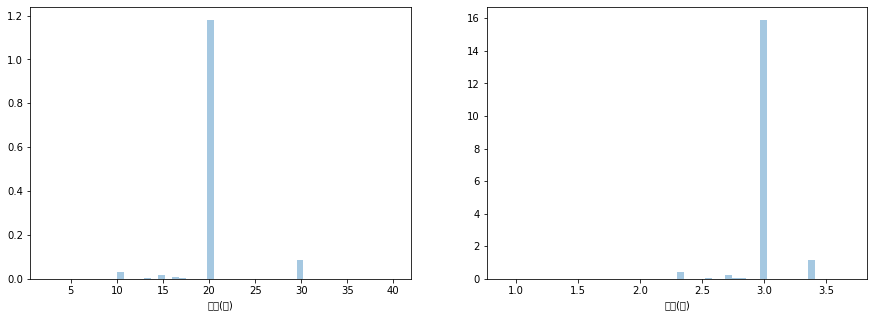

In [107]:
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.distplot(performance_data['노출(분)'],norm_hist='density', ax=ax1)
sns.distplot(performance_data['노출(분)'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)
plt.show()

In [108]:
performance_data['노출(분)'].skew()

0.949842819782917

In [109]:
performance_data['노출(분)'].map(lambda i: np.log(i) if i > 0 else 0).skew()

-1.6753012493251611

### **판매단가**

In [110]:
'''
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.distplot(performance_data['판매단가'], ax=ax1)
sns.distplot(performance_data['판매단가'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)
plt.show()
'''

"\nfigure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)\nfigure.set_size_inches(15,5)\nsns.distplot(performance_data['판매단가'], ax=ax1)\nsns.distplot(performance_data['판매단가'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)\nplt.show()\n"

In [111]:
performance_data['판매단가'].skew()

2.4045187817256806

In [112]:
performance_data['판매단가'].map(lambda i: np.log(i) if i > 0 else 0).skew()

0.7798123776104325

In [113]:
# 위 그래프를 보면 log를 취해 주었을 때 분포가 퍼지는 것을 볼 수 있다. 그래서 변형해 준다.

### **mean_rating**

In [114]:
'''
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.distplot(performance_data['mean_rating'], ax=ax1)
sns.distplot(performance_data['mean_rating'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)
plt.show()
'''

"\nfigure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)\nfigure.set_size_inches(15,5)\nsns.distplot(performance_data['mean_rating'], ax=ax1)\nsns.distplot(performance_data['mean_rating'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)\nplt.show()\n"

In [115]:
performance_data['mean_rating'].skew()

3.7803796554037974

In [116]:
performance_data['mean_rating'].map(lambda i: np.log(i) if i > 0 else 0).skew()

0.4805231142338703

In [117]:
# 위 그래프를 보면 log를 취해 주었을 때 분포가 퍼지는 것을 볼 수 있다. 그래서 변형해 준다.

### **누적강수량**

In [118]:
'''
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.distplot(performance_data['누적강수량'], ax=ax1)
sns.distplot(performance_data['누적강수량'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)
plt.show()
'''

"\nfigure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)\nfigure.set_size_inches(15,5)\nsns.distplot(performance_data['누적강수량'], ax=ax1)\nsns.distplot(performance_data['누적강수량'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)\nplt.show()\n"

In [119]:
performance_data['누적강수량'].skew()

5.980350457743225

In [120]:
performance_data['누적강수량'].map(lambda i: np.log(i) if i > 0 else 0).skew()

2.3504600529096247

In [121]:
# 이건 굳이.

### **거래량(천주)**

In [122]:
'''
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.distplot(performance_data['거래량(천주)'], ax=ax1)
sns.distplot(performance_data['거래량(천주)'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)
plt.show()
'''

"\nfigure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)\nfigure.set_size_inches(15,5)\nsns.distplot(performance_data['거래량(천주)'], ax=ax1)\nsns.distplot(performance_data['거래량(천주)'].map(lambda i: np.log(i) if i > 0 else 0), ax=ax2)\nplt.show()\n"

In [123]:
performance_data['거래량(천주)'].skew()

0.8253924916207366

In [124]:
performance_data['거래량(천주)'].map(lambda i: np.log(i) if i > 0 else 0).skew()

0.052386698937322895

### **편항된 변수에 log 씌워주기**

In [125]:
performance_data['판매단가'] = performance_data['판매단가'].map(lambda i: np.log(i) if i > 0 else 0)
performance_data['mean_rating'] = performance_data['mean_rating'].map(lambda i: np.log(i) if i > 0 else 0)

In [126]:
performance_data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,요일,...,저가지수,거래량(천주),거래대금(백만원),상장시가총액(백만원),뉴스시청률,prime_time,소분류,중분류,브랜드,group
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,10.594132,2099000.0,52.606516,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,1
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,10.594132,4371000.0,109.548872,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,1
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,10.594132,3262000.0,81.754386,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,2
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,10.594132,6955000.0,174.310777,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,2
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,10.594132,6672000.0,167.218045,화요일,...,2035.41,352678.0,4120696.0,1.343972e+09,11.8,no_prime,니트,스웨터,테이트,3


In [128]:
with open('../data/merged_data_concat_0921.pickle', 'wb') as f:
    pickle.dump(performance_data, f)

In [130]:
performance_data.to_csv('../data/merged_data_concat_0921.csv',index=False)

### **추가로 만들어야 할 변수**
* 상품명에 무이자, 일시불 포함한 경우 라벨
* 상품명에 여성, 남성이 들어간 경우 분명한 차이 존재
* 계절별상품
* 브랜드
* 명품
* 미성이가 만든건 소분류, 내가 만들건 중분류

In [131]:
def make_gender(x) : 
    if (('남성' in  x) or ('남자' in x ) or ('드로즈' in x) or ('트렁크' in x) or ('머슬' in x) or ('수트' in x)
       or ('낚시' in x) or ('면도기' in x)): 
        return('남성')
    elif (('여성' in  x) or ('여자' in x ) or ('브라' in x) or ('란쥬' in x) 
          or ('코르셋' in x) or ('다이어트' in x) or ('귀걸이' in x) or ('목걸이' in x) or ('레이프릴' in x)
          or ('반지' in x) or ('팔찌' in x) or ('주얼리' in x) or ('보석' in x) or ('악어' in x) 
          or ('밍크' in x) or ('쉬폰' in x) or ('라라츄' in x) or ('눈썹' in x) or ('라라쎄' in x) or ('립스틱' in x)
          or ('주얼리' in x) or ('네일' in x) or ('원피스' in x) or ('아이라이너' in x) or ('브로우' in x) 
          or ('아이스타일러' in x) or ('염색' in x) or ('이지탑' in x) or ('이지웨어' in x) or ('레깅스' in x)
          or ('커버쿠션' in x) or ('레이스' in x) or ('드레스' in x) or ('치마' in x) or ('틴트' in x)): 
        return('여성') 
    else : return('all')

In [132]:
performance_data['남여'] = performance_data.상품명.apply(lambda x: make_gender(x))
performance_data['남여'].value_counts()

all    28430
여성      5299
남성      4366
Name: 남여, dtype: int64

In [133]:
def make_mu(x):
    if ('무이자' in x) or ('(무)' in x):
        return ('무이자')
    elif ('일시불' in x) or ('(일)' in x):
        return ('일시불')
    else:
        return ('둘다아님')

In [134]:
performance_data['muil'] = performance_data.상품명.apply(lambda x: make_mu(x))
performance_data['muil'].value_counts()

둘다아님    25091
일시불      6525
무이자      6479
Name: muil, dtype: int64

In [135]:
def make_season(x):
    if (('에어컨' in x) or ('선풍기' in x) or ('에어쿨러' in x) or ('써큘레이터' in x) or ('윈큘레이터' in x) 
        or ('물매트' in x) or ('무풍' in x)):
        return ('여름가전')
    elif ('온열' in x) or ('온수' in x) or ('에너지세이브' in x) or ('히터' in x):
        return ('겨울가전')
    elif (('S/S' in x) or ('SS' in x) or ('썸머' in x) or ('반팔' in x) or ('pk티셔츠' in x) or ('슬립온' in x)
          or ('샌들' in x) or (' 쿨 ' in x) or ('카라티셔츠' in x) or ('카라 티셔츠' in x) or ('카타티셔츠' in x)
          or ('에어윈디' in x) or ('쿨팬츠' in x) or (' 워터 ' in x) or ('PK티셔츠' in x) or ('반바지' in x) or ('린넨' in x)):
        return ('여름의류')
    elif (('F/W' in x) or ('자켓' in x) or ('코트' in x) or ('패딩' in x) or ('방한화' in x) or ('기모' in x) 
          or ('맨투맨' in x) or ('니트' in x) or ('재킷' in x)  or ('FW' in x) or ('밍크' in x) or ('구스다운' in x)
          or ('덕다운' in x) or ('스웨터' in x) or ('터틀넥' in x) or ('모크넥' in x) or ('웜웨어' in x) or ('무스탕' in x)
          or ('윈터' in x)):
        return ('겨울의류')
    elif ('양산' in x) or ('선글라스' in x) or ('썬스틱' in x) or ('선스틱' in x) or ('선크림' in x) or ('선쿠션' in x):
        return ('여름잡화')
    elif ('단열벽지' in x):
        return ('겨울잡화')
    elif ('삼계탕' in x) or ('콩국수' in x) or ('바다장어' in x):
        return ('여름식품')
    elif ('귤' in x) or ('참굴' in x) or ('호빵' in x):
        return ('겨울식품')
    else:
        return ('all')

In [136]:
performance_data['season_prod'] = performance_data.상품명.apply(lambda x: make_season(x))
performance_data['season_prod'].value_counts()

all     30464
여름의류     2684
겨울의류     2407
여름가전     1300
겨울가전      674
여름잡화      370
여름식품      133
겨울잡화       45
겨울식품       18
Name: season_prod, dtype: int64

In [137]:
performance_data_2 = performance_data[performance_data.취급액 != -1]

In [138]:
middle_class_uni = {}
for i in performance_data_2['중분류'].unique():
    middle_class_uni[i] = performance_data_2[performance_data_2['중분류']==i]['취급액'].mean()

middle_class_uni_2 = {}
for i in performance_data_2['소분류'].unique():
    middle_class_uni_2[i] = performance_data_2[performance_data_2['소분류']==i]['취급액'].mean()

In [139]:
def meaning_f(x,m):
    return m[x]
performance_data_2['취급액_mean'] = performance_data_2['중분류'].apply(lambda x: meaning_f(x,middle_class_uni))
performance_data_2['취급액_mean_소분류'] = performance_data_2['소분류'].apply(lambda x: meaning_f(x,middle_class_uni_2))

In [140]:
middle_class_uni_quantile = {}
middle_class_uni_quantile[0] = 0
for i in range(1,11):
    middle_class_uni_quantile[i] = performance_data_2['취급액_mean'].quantile(i/10)

middle_class_uni_quantile_2 = {}
middle_class_uni_quantile_2[0] = 0
for i in range(1,11):
    middle_class_uni_quantile_2[i] = performance_data_2['취급액_mean_소분류'].quantile(i/10)

In [141]:
def meaning_f_quantile(x,m):
    for i in range(10):
        if m[i]<x and x<=m[i+1]:
            return i
performance_data_2['취급액_mean_quantile_10'] = performance_data_2['취급액_mean'].apply(lambda x: meaning_f_quantile(x,middle_class_uni_quantile))
performance_data_2['취급액_mean_quantile_10_소분류'] = performance_data_2['취급액_mean_소분류'].apply(lambda x: meaning_f_quantile(x,middle_class_uni_quantile_2))

In [142]:
performance_data_2['취급액_log'] = np.log(performance_data_2['취급액'])

In [143]:
middle_class_uni_log = {}
for i in performance_data_2['중분류'].unique():
    middle_class_uni_log[i] = performance_data_2[performance_data_2['중분류']==i]['취급액_log'].mean()

middle_class_uni_log_2 = {}
for i in performance_data_2['소분류'].unique():
    middle_class_uni_log_2[i] = performance_data_2[performance_data_2['소분류']==i]['취급액_log'].mean()

In [144]:
def meaning_f_log(x,m):
    return m[x]
performance_data_2['취급액_mean_log'] = performance_data_2['중분류'].apply(lambda x: meaning_f_log(x,middle_class_uni_log))
performance_data_2['취급액_mean_log_소분류'] = performance_data_2['소분류'].apply(lambda x: meaning_f_log(x,middle_class_uni_log_2))

In [145]:
middle_class_uni_quantile_log = {}
middle_class_uni_quantile_log[0] = 0
for i in range(1,11):
    middle_class_uni_quantile_log[i] = performance_data_2['취급액_mean_log'].quantile(i/10)
    
middle_class_uni_quantile_log_2 = {}
middle_class_uni_quantile_log_2[0] = 0
for i in range(1,11):
    middle_class_uni_quantile_log_2[i] = performance_data_2['취급액_mean_log_소분류'].quantile(i/10)

In [146]:
def meaning_f_quantile_log(x,m):
    for i in range(10):
        if m[i]<x and x<=m[i+1]:
            return i
performance_data_2['취급액_mean_log_quantile_10'] = performance_data_2['취급액_mean_log'].apply(lambda x: meaning_f_quantile_log(x,middle_class_uni_quantile_log))
performance_data_2['취급액_mean_log_quantile_10_소분류'] = performance_data_2['취급액_mean_log_소분류'].apply(lambda x: meaning_f_quantile_log(x,middle_class_uni_quantile_log_2))

In [147]:
performance_data_2 = performance_data_2.drop(['취급액_mean','취급액_log','취급액_mean_log','취급액_mean_소분류','취급액_mean_log_소분류'],axis=1)

In [148]:
idx = performance_data_2['중분류'].unique()
val1 = {}
val2 = {}

for i in idx:
    val1[i] = performance_data_2[performance_data_2['중분류']==i].reset_index()['취급액_mean_quantile_10'][0]
    val2[i] = performance_data_2[performance_data_2['중분류']==i].reset_index()['취급액_mean_log_quantile_10'][0]
    
idx = performance_data_2['소분류'].unique()
val3 = {}
val4 = {}

for i in idx:
    val3[i] = performance_data_2[performance_data_2['소분류']==i].reset_index()['취급액_mean_quantile_10_소분류'][0]
    val4[i] = performance_data_2[performance_data_2['소분류']==i].reset_index()['취급액_mean_log_quantile_10_소분류'][0]

In [149]:
performance_data['취급액_mean_quantile_10'] = 0
performance_data['취급액_mean_log_quantile_10'] = 0

for i in tqdm(range(performance_data.shape[0])):
    performance_data['취급액_mean_quantile_10'][i] = val1[performance_data['중분류'][i]]
    performance_data['취급액_mean_log_quantile_10'][i] = val2[performance_data['중분류'][i]]  

    
performance_data['취급액_mean_quantile_10_소분류'] = 0
performance_data['취급액_mean_log_quantile_10_소분류'] = 0

for i in tqdm(range(performance_data.shape[0])):
    performance_data['취급액_mean_quantile_10_소분류'][i] = val3[performance_data['소분류'][i]]
    performance_data['취급액_mean_log_quantile_10_소분류'][i] = val4[performance_data['소분류'][i]]

100%|██████████| 38095/38095 [00:05<00:00, 6484.14it/s]


In [150]:
def expensive(x):
    if x in ['농수축','이미용']:
        return 1
    else:
        return 0
performance_data_2['expensive'] = performance_data_2['상품군'].apply(lambda x: expensive(x))
performance_data['expensive'] = performance_data['중분류'].apply(lambda x: expensive(x))

In [151]:
def mid(x):
    if x in ['의류','건강기능','속옷']:
        return 1
    else:
        return 0
performance_data_2['mid'] = performance_data_2['상품군'].apply(lambda x: mid(x))
performance_data['mid'] = performance_data['상품군'].apply(lambda x: mid(x))

In [152]:
def cheap0(x):
    if x in ['가구','침구']:
        return 1
    else:
        return 0
performance_data_2['cheap0'] = performance_data_2['상품군'].apply(lambda x: cheap0(x))
performance_data['cheap0'] = performance_data['상품군'].apply(lambda x: cheap0(x))

In [153]:
def weekend(x):
    if x in ['토요일','일요일']:
        return 1
    else:
        return 0
performance_data_2['weekend'] = performance_data_2['요일'].apply(lambda x: weekend(x))
performance_data['weekend'] = performance_data['요일'].apply(lambda x: weekend(x))

In [154]:
def middle_class(x):
    if x in ['의자', '레드빈', '언더탑', '암막', '반지', '면도날', '메모리폼', '벽지']:
        return 1
    elif x in ['리클라이너', '장', '철갑상어', '히비스커스']:
        return 2
    elif x in ['클렌징', '마스크팩']:
        return 3
    elif x in ['굴비']:
        return 4
    elif x in ['오징어', '꼬막', '랍스터']:
        return 5
    else:
        return 0
performance_data_2['middle_class'] = performance_data_2['중분류'].apply(lambda x: middle_class(x))
performance_data['middle_class'] = performance_data['중분류'].apply(lambda x: middle_class(x))

In [155]:
def prod_size(x):
    
    if (all(format in x for format in ['침대' , 'SK']) or all(format in x for format in ['침대' , '슈퍼킹'])
          or all(format in x for format in ['침구' , '슈퍼킹']) or all(format in x for format in ['타퍼' , '슈퍼킹']) or all(format in x for format in ['침구' , 'SK'])
          or all(format in x for format in ['타퍼' , 'SK']) or all(format in x for format in ['매트리스' , '슈퍼킹']) or all(format in x for format in ['매트리스' , 'SK'])
          or all(format in x for format in ['6인용' , '소파'])):
        return (5)
    elif (all(format in x for format in ['침대' , 'K']) or all(format in x for format in ['침대' , '킹'])
          or all(format in x for format in ['침구' , '킹']) or all(format in x for format in ['타퍼' , '킹']) or all(format in x for format in ['침구' , 'K'])
          or all(format in x for format in ['타퍼' , 'K']) or all(format in x for format in ['매트리스' , '킹']) or all(format in x for format in ['매트리스' , 'K'])
          or ('슈퍼특대형' in x) or ('점보특대형' in x) or all(format in x for format in ['10인용' , '밥솥']) or all(format in x for format in ['무풍' , '19'])
          or all(format in x for format in ['무풍' , '18']) or all(format in x for format in ['에어컨' , '19'])):
        return (4)
    elif (all(format in x for format in ['침대' , 'Q']) or all(format in x for format in ['침대' , '퀸'])
          or all(format in x for format in ['침구' , '퀸']) or all(format in x for format in ['타퍼' , '퀸']) or all(format in x for format in ['침구' , 'Q'])
          or all(format in x for format in ['타퍼' , 'Q']) or all(format in x for format in ['매트리스' , '퀸']) or all(format in x for format in ['매트리스' , 'Q'])
          or ('특대형' in x) or ('4인용' in x) or ('패밀리' in x)):
        return (3)
    elif (all(format in x for format in ['침대' , 'SS']) or all(format in x for format in ['침대' , '슈퍼싱글'])
          or all(format in x for format in ['침구' , '슈퍼싱글']) or all(format in x for format in ['타퍼' , '슈퍼싱글']) or all(format in x for format in ['침구' , 'SS'])
          or all(format in x for format in ['타퍼' , 'SS']) or all(format in x for format in ['매트리스' , '슈퍼싱글']) or all(format in x for format in ['매트리스' , 'SS'])
          or ('대형' in x) or all(format in x for format in ['6인용' , '밥솥']) or all(format in x for format in ['무풍' , '17'])
          or all(format in x for format in ['무풍' , '16']) or all(format in x for format in ['에어컨' , '17'])):
        return (2)
    elif (all(format in x for format in ['침대' , 'S']) or all(format in x for format in ['침대' , '싱글'])
          or all(format in x for format in ['침구' , '싱글']) or all(format in x for format in ['타퍼' , '싱글']) or all(format in x for format in ['침구' , 'S'])
          or all(format in x for format in ['타퍼' , 'S']) or all(format in x for format in ['매트리스' , '싱글']) or all(format in x for format in ['매트리스' , 'S'])
          or ('3인용' in x) or ('중형' in x)):
        return (1)
    
    elif (all(format in x for format in ['55' , 'TV'])):
        return (1)
    elif (all(format in x for format in ['65' , 'TV'])):
        return (2)
    elif (all(format in x for format in ['75' , 'TV'])):
        return (4)
    elif (all(format in x for format in ['70' , 'TV'])):
        return (3)
    
    elif (all(format in x for format in ['벽걸이' , '06'])):
        return (1)
    elif (all(format in x for format in ['벽걸이' , '07'])):
        return (2)
    elif (all(format in x for format in ['벽걸이' , '09'])):
        return (3)
    elif (all(format in x for format in ['벽걸이' , '10'])):
        return (4)
    elif (all(format in x for format in ['벽걸이' , '11'])):
        return (5)
    elif (all(format in x for format in ['벽걸이' , '13'])):
        return (6)
    else:
        return (0)


In [156]:
performance_data['prod_size'] = performance_data.상품명.apply(lambda x: prod_size(x))
performance_data['prod_size'].value_counts()

0    28253
2     3850
4     2945
1     1504
3     1260
5      271
6       12
Name: prod_size, dtype: int64

In [157]:
with open('../data/0924_naver.pickle', 'rb') as f:
    naver = pickle.load(f)

In [158]:
with open('../data/merged_data_concat_0926.pickle', 'wb') as f:
    pickle.dump(performance_data, f)

In [159]:
performance_data.to_csv('../data/merged_data_concat_0926.csv',index=False)

In [195]:
# from sklearn.decomposition import PCA

In [237]:
# def make_pca(data,idx_col,col):
#     a = pd.pivot_table(data, index=idx_col, columns=col, values='취급액',
#                    aggfunc=np.size, fill_value=0).reset_index()
#     x = pd.merge(data[idx_col],a,on=idx_col, how='left').iloc[:,len(idx_col):]
    
#     pca = PCA(n_components=len(x.columns))
#     pca.fit(x)
#     cumsum = np.cumsum(pca.explained_variance_ratio_)
#     n_pca = np.argmax(cumsum >= 0.90) + 1 

#     pca = PCA(n_components=n_pca)
#     principalComponents = pca.fit_transform(x)

#     result = pd.DataFrame(principalComponents)
#     result.columns = [col + '_' + str(column) for column in result.columns]
#     return result


In [235]:
# a = pd.pivot_table(performance_data, index=['hour','요일'], columns='상품군', values='취급액',
#                    aggfunc=np.size, fill_value=0).reset_index()
# b = pd.merge(performance_data[['hour','요일']],a,on=['hour','요일'], how='left').iloc[:,2:]


,가구,가전,건강기능,농수축,생활용품,속옷,의류,이미용,잡화,주방,침구
0,0,0,15,3,29,31,54,11,19,26,0
1,0,0,15,3,29,31,54,11,19,26,0
2,0,0,15,3,29,31,54,11,19,26,0
3,0,0,15,3,29,31,54,11,19,26,0
4,0,0,15,3,29,31,54,11,19,26,0
...,...,...,...,...,...,...,...,...,...,...,...
38090,15,6,9,0,56,62,54,9,55,15,0
38091,15,6,9,0,56,62,54,9,55,15,0
38092,15,6,9,0,56,62,54,9,55,15,0
38093,2,0,10,6,26,47,58,15,51,2,57


In [ ]:
# performance_data = pd.concat([performance_data,make_pca(performance_data,['hour','요일'],'소분류')],axis=1)

In [251]:
# performance_data = performance_data.drop(list(performance_data.columns[53:81]),axis=1)